In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from time import time
from scipy.signal import gaussian

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import numpy as np
from tabulate import tabulate
import pandas as pd
import pickle

from collections import defaultdict
models_scores_per_loss = defaultdict(dict)

In [ ]:
# Set a random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>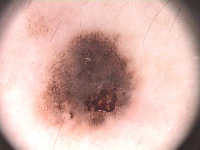</td><td>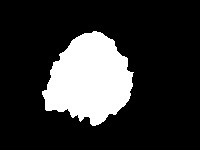</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# !wget -O PH2Dataset.rar -c https://drive.google.com/file/d/1qwPMy6MD3je-4xyPmHaH8DseZW_4t_ju
!pip install gdown

!gdown https://drive.google.com/uc?id=1qwPMy6MD3je-4xyPmHaH8DseZW_4t_ju



Downloading...
From: https://drive.google.com/uc?id=1qwPMy6MD3je-4xyPmHaH8DseZW_4t_ju
To: /content/hw6.rar
100% 116M/116M [00:01<00:00, 98.6MB/s]


In [ ]:
!ls

hw6.rar  sample_data


In [ ]:
get_ipython().system_raw("unrar x hw6.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

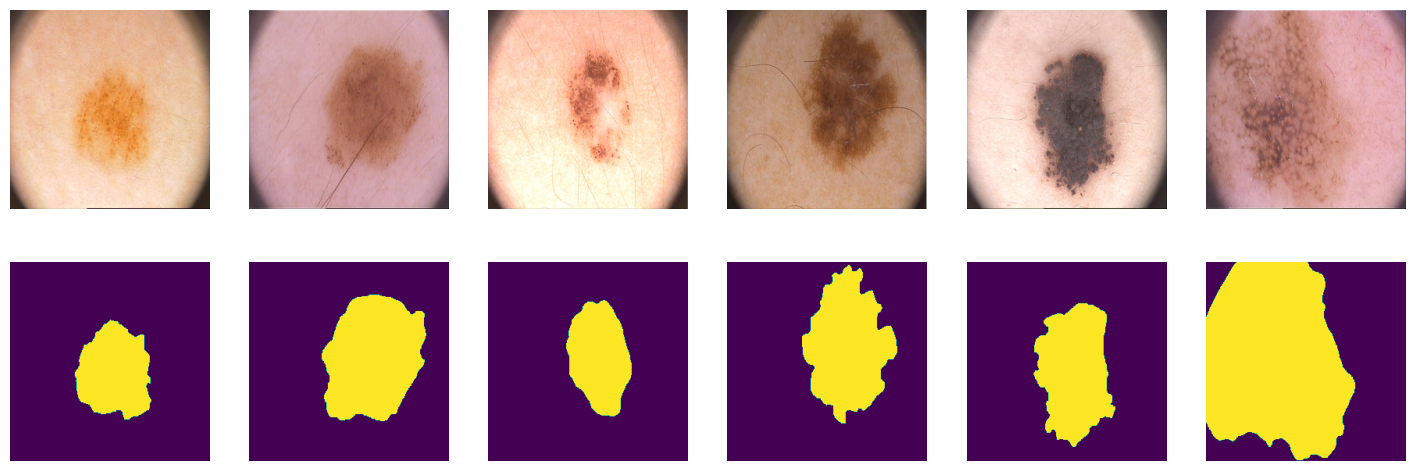

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

Here are the detailed differences between SegNet and UNet:

Architecture:

SegNet: Utilizes an encoder-decoder architecture without skip connections. The encoder consists of convolutional layers followed by pooling layers, and the decoder uses corresponding upsampling layers to restore the original resolution.
UNet: Also uses an encoder-decoder architecture but includes skip connections between corresponding layers of the encoder and decoder. This allows feature maps from the encoder to be concatenated with the corresponding decoder layers.

Skip Connections:

SegNet: Does not include skip connections. The architecture relies solely on the encoder-decoder pathway, which can result in a loss of spatial information.
UNet: Incorporates skip connections that directly transfer feature maps from the encoder to the decoder. This helps to preserve spatial information and improve the accuracy of the segmentation, especially for finer details.

Pooling and Upsampling:

SegNet: Uses max-pooling indices for upsampling in the decoder. This approach saves memory but might result in less accurate reconstruction of the original image resolution.
UNet: Uses transposed convolutions (also known as deconvolutions) for upsampling, which allows for a more precise reconstruction of the original image resolution.

Application Areas:

SegNet: Often used in real-time applications like autonomous driving due to its memory efficiency and relatively faster performance.
UNet: Commonly used in medical imaging and other applications requiring high accuracy because the skip connections enable better localization and segmentation of small features.

Performance:

SegNet: Generally more efficient in terms of memory usage, making it suitable for scenarios where computational resources are limited.
UNet: Tends to achieve higher segmentation accuracy due to its skip connections, which help retain more detailed information from the input images.


-----------------------------------------------------------------------------------------

# SegNet [2 балла]

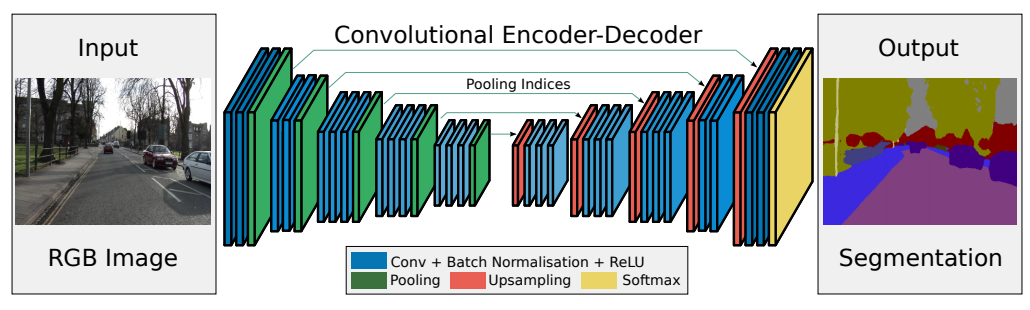

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
class SegNet(nn.Module):

  def __init__(self):
    super(SegNet, self).__init__()

    # Encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
    self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 128 -> 64

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

    # Bottleneck
    # Bottleneck with max pooling and unpooling
    self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.bottleneck_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
        )

    # Decoder (upsampling)
    self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )

    self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )

    self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 128 -> 256
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
    )


  def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # Bottleneck with max pooling
        b = self.bottleneck_conv(e3)
        b, ind_bottleneck = self.bottleneck_pool(b)
        b = self.bottleneck_unpool(b, ind_bottleneck)
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3, output_size=e2.size()))
        d1 = self.dec_conv1(self.upsample1(d0, ind2, output_size=e1.size()))
        d2 = self.dec_conv2(self.upsample2(d1, ind1, output_size=e0.size()))
        d3 = self.dec_conv3(self.upsample3(d2, ind0, output_size=x.size()))

        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    history = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):

        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            train_loss += loss / len(data_tr)
        toc = time()
        # print('loss: %f' % train_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          Y_hat = model(X_val.to(device)).cpu().detach()
          val_loss = loss_fn(Y_val, Y_hat)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+6+ 1)
            plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real label')
            plt.axis('off')

            plt.subplot(3, 6, k+6*2 + 1)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - train loss: %f , val loss: %f ' % (epoch+1, epochs, train_loss, val_loss))
        plt.show()

        history.append((train_loss.cpu().detach(),val_loss.cpu().detach()))

        # At the end of a training iteration or epoch, before the next iteration/epoch
        if torch.cuda.is_available():
          with torch.no_grad():
            torch.cuda.empty_cache()
    return history



## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_batch in data:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # Forward pass to get predictions
            Y_pred_logits = model(X_batch)
            Y_pred = (torch. sigmoid(Y_pred_logits) >0.5). float()

            # Calculate the metric for the batch and accumulate
            scores += metric(Y_pred, Y_batch).mean().item()

    return scores/len(data)

In [ ]:
def plot_loss_history(history):
  train_loss, val_loss = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(train_loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

In [ ]:
def save_stats(stats, suffix="xxxx"):
    # Save dictionary to disk
    file_path = f'/content/gdrive/MyDrive/hw5_{suffix}.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump(stats, file)
    return file_path

def load_stats(suffix="xxxx"):
    # Load dictionary from disk
    file_path = f'/content/gdrive/MyDrive/hw5_{suffix}.pkl'
    with open(file_path, 'rb') as file:
        stats = pickle.load(file)
    return stats



In [ ]:
def print_model_scores_table(model_scores):

  # Convert the dictionary to a DataFrame
  df = pd.DataFrame(model_scores)

  # Display the DataFrame using the tabulate library
  table = tabulate(df, headers='keys', tablefmt='fancy_grid')

  # Print the table
  print(table)

In [ ]:
models_losses_per_loss = defaultdict(dict)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred_logit):
    # please don't use nn.BCELoss. write it from scratch
    SMOOTH = 1e-8
    loss = y_pred_logit - torch.mul(y_real, y_pred_logit) + torch.log(1 + torch.exp(-y_pred_logit) + SMOOTH)
    return torch.mean(loss)

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_segnet_bce = SegNet().to(device)

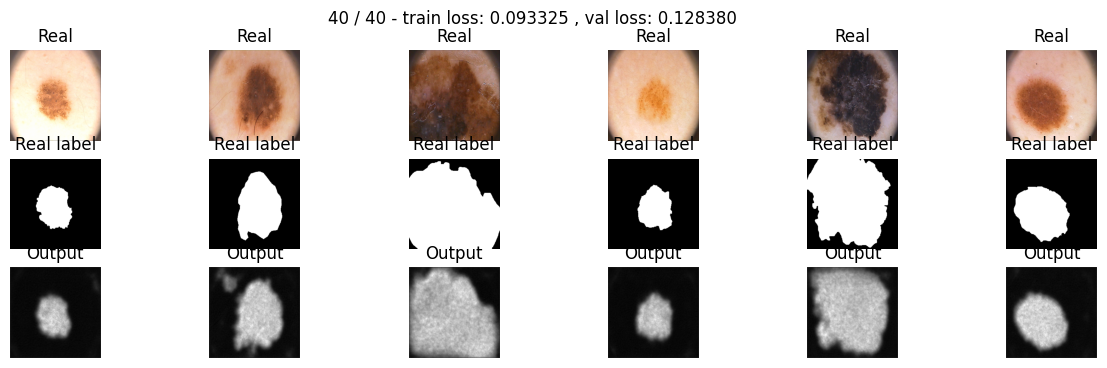

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model_segnet_bce.parameters(), lr=0.0001)
history_segnet_bce = train(model_segnet_bce, optim, bce_loss, max_epochs, data_tr, data_val)

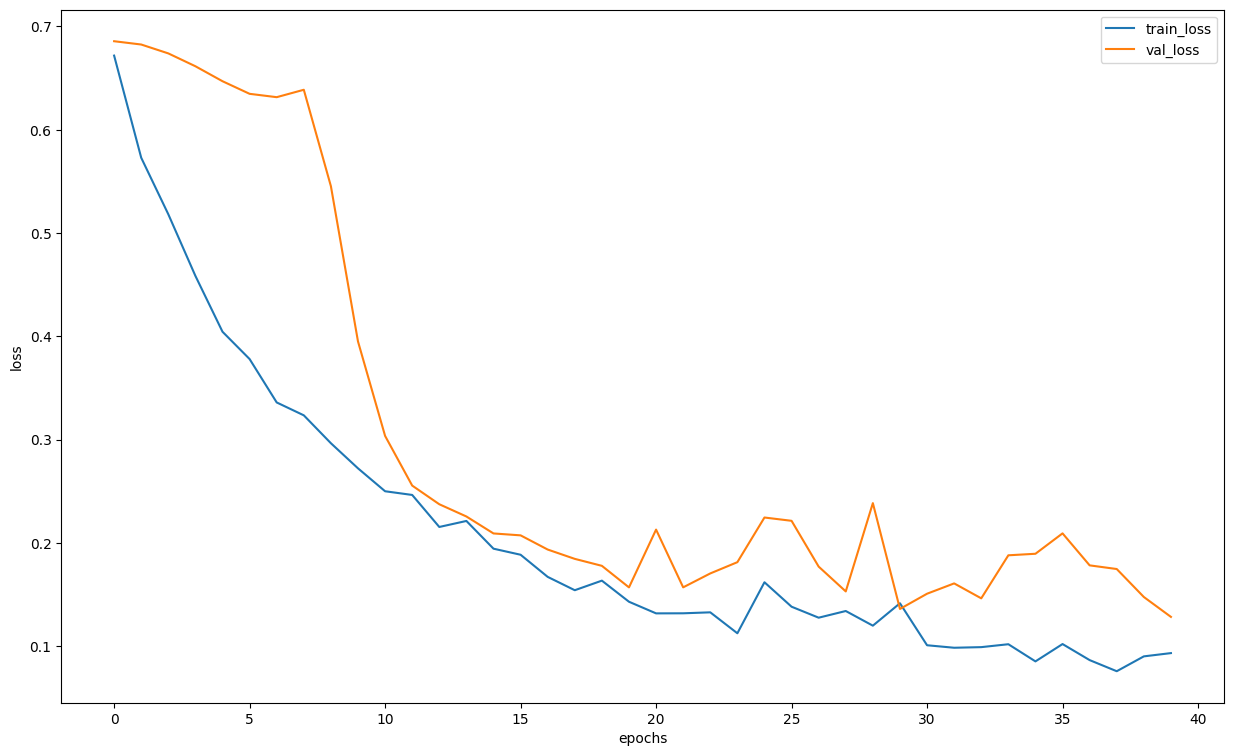

'/content/gdrive/MyDrive/hw5_history_segnet_bce.pkl'

In [ ]:
plot_loss_history(history_segnet_bce)
save_stats(history_segnet_bce, suffix="history_segnet_bce")

In [ ]:
regnet_bce_scores = []
regnet_bce_scores.append(score_model(model_segnet_bce, iou_pytorch, data_tr))
regnet_bce_scores.append(score_model(model_segnet_bce, iou_pytorch, data_val))
regnet_bce_scores.append(score_model(model_segnet_bce, iou_pytorch, data_ts))
models_scores_per_loss['regnet\ntrain/val/test']['bce'] = regnet_bce_scores

In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_regnet_bce")

╒═════╤═════════════════════════════════════════════════════════════╕
│     │ regnet                                                      │
│     │ train/val/test                                              │
╞═════╪═════════════════════════════════════════════════════════════╡
│ bce │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186] │
╘═════╧═════════════════════════════════════════════════════════════╛


'/content/gdrive/MyDrive/hw5_models_scores_per_loss_regnet_bce.pkl'

Ответьте себе на вопрос: не переобучается ли моя модель?

Answer: Based on 3 scores (tr_score, val_score, ts_score) there might be some level of overfitting.
The training accuracy (0.896) is significantly higher than the validation (0.78) and test (0.70)accuracies, indicating that the model might be fitting the training data too closely.


-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred_logit):
  y_pred = torch.sigmoid(y_pred_logit)
  SMOOTH = 1e-8
  intersection = torch.sum(y_real * y_pred)
  union = torch.sum(y_real) + torch.sum(y_pred)

  # Calculate Dice Coefficient
  # We smooth our devision to avoid 0/0
  dice_coefficient = ((2.0 * intersection) + SMOOTH) / (union + intersection + SMOOTH)

  # Calculate Dice Loss
  dice_loss = 1.0 - dice_coefficient

  return dice_loss


Проводим тестирование:

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_segnet_dice = SegNet().to(device)

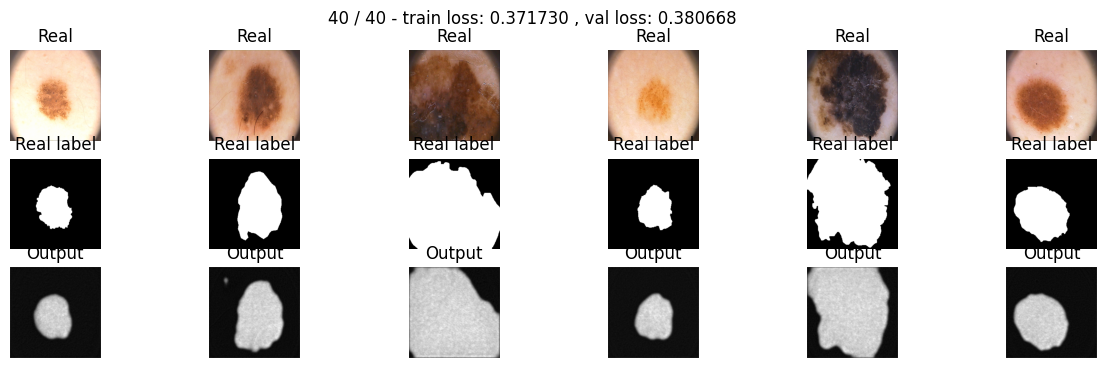

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model_segnet_dice.parameters(),lr=0.0001)
history_segnet_dice = train(model_segnet_dice, optim, dice_loss, max_epochs, data_tr, data_val)

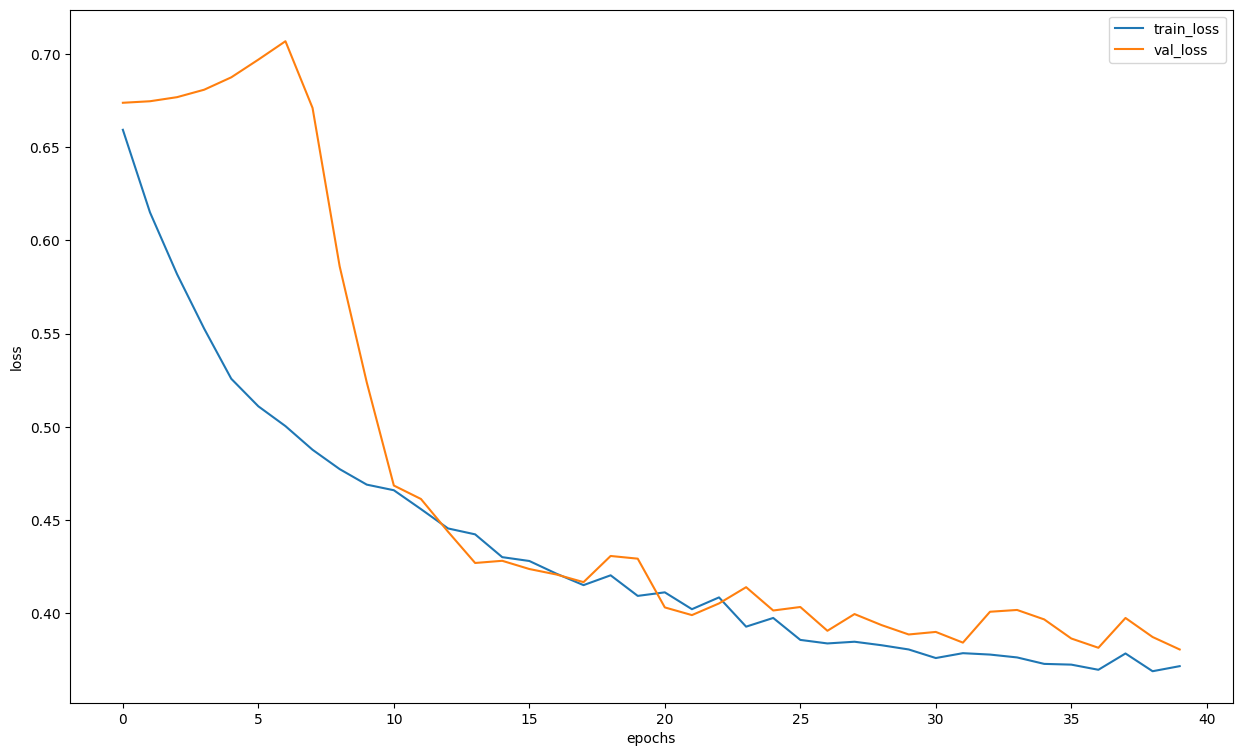

'/content/gdrive/MyDrive/hw5_history_segnet_dice.pkl'

In [ ]:
plot_loss_history(history_segnet_dice)
save_stats(history_segnet_dice, suffix="history_segnet_dice")

In [ ]:
regnet_dice_scores = []
regnet_dice_scores.append(score_model(model_segnet_dice, iou_pytorch, data_tr))
regnet_dice_scores.append(score_model(model_segnet_dice, iou_pytorch, data_val))
regnet_dice_scores.append(score_model(model_segnet_dice, iou_pytorch, data_ts))
models_scores_per_loss['regnet\ntrain/val/test']['dice'] = regnet_dice_scores

In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_regnet_dice")

╒══════╤═════════════════════════════════════════════════════════════╕
│      │ regnet                                                      │
│      │ train/val/test                                              │
╞══════╪═════════════════════════════════════════════════════════════╡
│ bce  │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186] │
├──────┼─────────────────────────────────────────────────────────────┤
│ dice │ [0.8469999879598618, 0.75, 0.695999950170517]               │
╘══════╧═════════════════════════════════════════════════════════════╛


'/content/gdrive/MyDrive/hw5_models_scores_per_loss_regnet_dice.pkl'

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


The gamma parameter controls the degree of focusing on hard-to-classify examples. Here are some general guidelines:

Small Values (e.g., 0.5 or 1): Use a smaller gamma if you want to provide a modest boost to the importance of hard-to-classify examples. This is often a good starting point.

Moderate Values (e.g., 2 or 3): A moderate gamma places more emphasis on difficult examples. This might be useful when dealing with imbalanced datasets where the minority class is crucial.

Large Values (e.g., 5 or higher): Using a larger gamma significantly amplifies the impact of hard-to-classify examples. This can be appropriate in cases where correctly classifying challenging instances is of utmost importance.

In [ ]:
def focal_loss(y_real, y_pred_logit, eps=1e-8, gamma=2):
  y_pred = torch.sigmoid(y_pred_logit)
  y_pred = torch.clamp(y_pred, eps, 1 - eps)
  SMOOTH = 1e-8
  loss = - ((1 - y_pred) ** gamma) * y_real * torch.log(y_pred + SMOOTH) - (1 - y_real) * torch.log(1 - y_pred + SMOOTH)
  return torch.mean(loss)


In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_segnet_focal = SegNet().to(device)

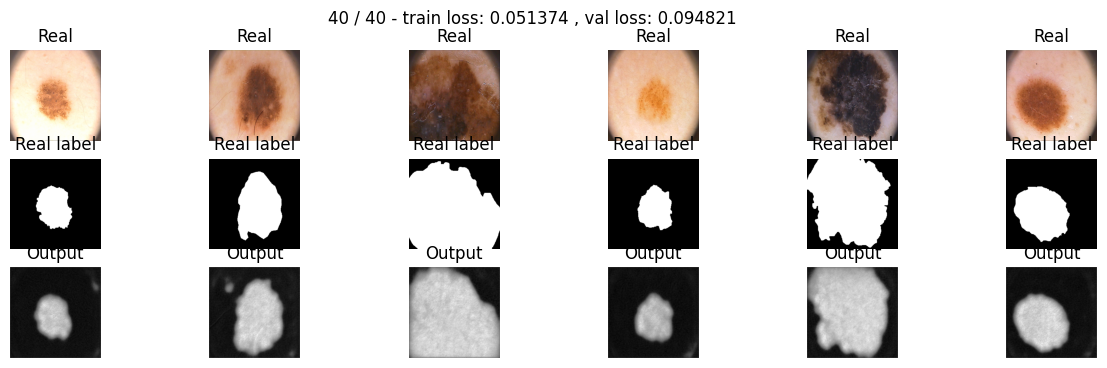

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model_segnet_focal.parameters(), lr=0.0001)
history_segnet_focal = train(model_segnet_focal, optim, focal_loss, max_epochs, data_tr, data_val)

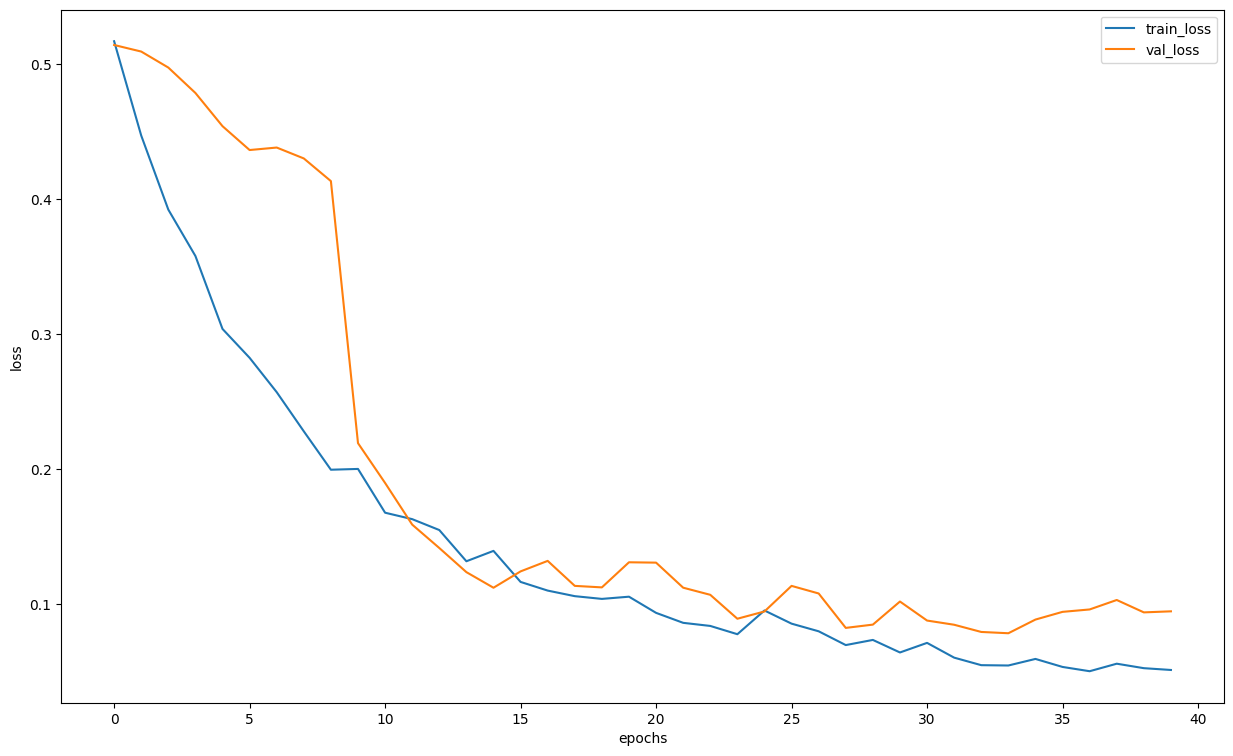

'/content/gdrive/MyDrive/hw5_history_segnet_focal.pkl'

In [ ]:
plot_loss_history(history_segnet_focal)
save_stats(history_segnet_focal, suffix="history_segnet_focal")

In [ ]:
regnet_focal_scores = []
regnet_focal_scores.append(score_model(model_segnet_focal, iou_pytorch, data_tr))
regnet_focal_scores.append(score_model(model_segnet_focal, iou_pytorch, data_val))
regnet_focal_scores.append(score_model(model_segnet_focal, iou_pytorch, data_ts))
models_scores_per_loss['regnet\ntrain/val/test']['focal'] = regnet_focal_scores

In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_regnet_focal")

╒═══════╤═════════════════════════════════════════════════════════════╕
│       │ regnet                                                      │
│       │ train/val/test                                              │
╞═══════╪═════════════════════════════════════════════════════════════╡
│ bce   │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186] │
├───────┼─────────────────────────────────────────────────────────────┤
│ dice  │ [0.8469999879598618, 0.75, 0.695999950170517]               │
├───────┼─────────────────────────────────────────────────────────────┤
│ focal │ [0.877000018954277, 0.7540000081062317, 0.6859999895095825] │
╘═══════╧═════════════════════════════════════════════════════════════╛


'/content/gdrive/MyDrive/hw5_models_scores_per_loss_regnet_focal.pkl'

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

1. First let's try tversky_loss from  [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721) which based on the Tversky index to address the issue of data imbalance


In [ ]:
def tversky_loss(y_true, y_pred_logit, alpha=0.5, beta=0.5, smooth=1e-8):
  y_pred = torch.sigmoid(y_pred_logit)
  # Calculate true positives, false positives, and false negatives
  tp = torch.sum(y_true * y_pred)
  fp = torch.sum((1 - y_true) * y_pred)
  fn = torch.sum(y_true * (1 - y_pred))

  # Calculate Tversky coefficient
  tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)

  # Calculate Tversky loss
  tversky_loss = 1 - tversky

  return tversky_loss



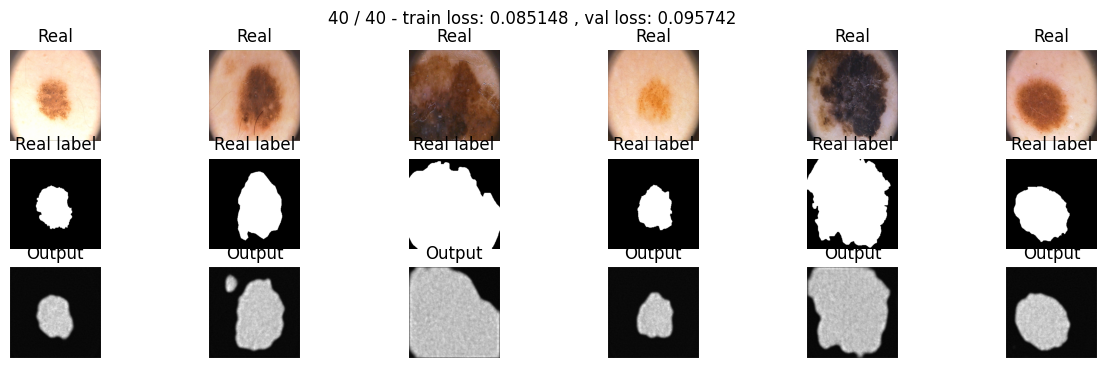

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_segnet_tversky = SegNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(model_segnet_tversky.parameters(), lr=0.0001)
history_segnet_tversky = train(model_segnet_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

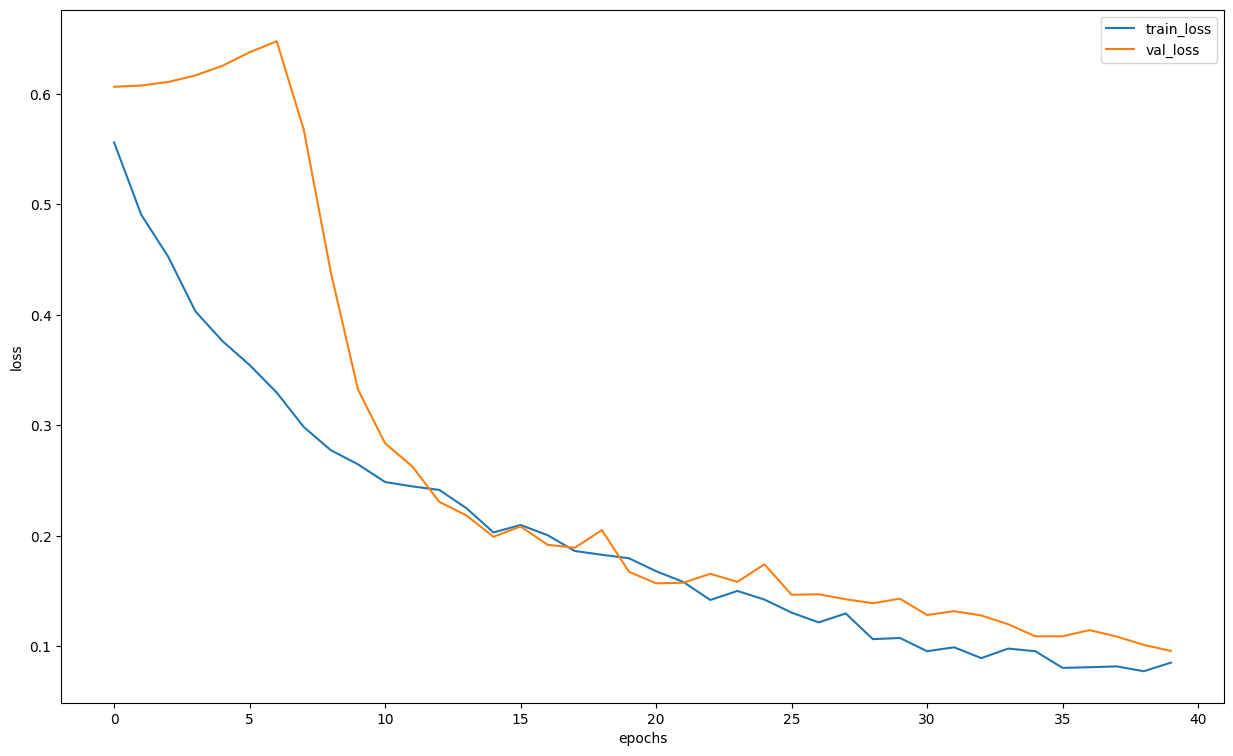

'/content/gdrive/MyDrive/hw5_history_segnet_tversky.pkl'

In [ ]:
plot_loss_history(history_segnet_tversky)
save_stats(history_segnet_tversky, suffix="history_segnet_tversky")

In [ ]:
segnet_tversky_scores = []
segnet_tversky_scores.append(score_model(model_segnet_tversky, iou_pytorch, data_tr))
segnet_tversky_scores.append(score_model(model_segnet_tversky, iou_pytorch, data_val))
segnet_tversky_scores.append(score_model(model_segnet_tversky, iou_pytorch, data_ts))
models_scores_per_loss['regnet\ntrain/val/test']['tversky'] = segnet_tversky_scores

In [ ]:
models_losses_per_loss['regnet']['bce'] = history_segnet_bce
models_losses_per_loss['regnet']['dice'] = history_segnet_dice
models_losses_per_loss['regnet']['focal'] = history_segnet_focal
models_losses_per_loss['regnet']['tversky'] = history_segnet_tversky

In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_regnet_tversky")

╒═════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │
│         │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │
├─────────┼──────────────────────────────────────────────────────────────┤
│ dice    │ [0.8469999879598618, 0.75, 0.695999950170517]                │
├─────────┼──────────────────────────────────────────────────────────────┤
│ focal   │ [0.877000018954277, 0.7540000081062317, 0.6859999895095825]  │
├─────────┼──────────────────────────────────────────────────────────────┤
│ tversky │ [0.8520000129938126, 0.8019999861717224, 0.6839999854564667] │
╘═════════╧══════════════════════════════════════════════════════════════╛


'/content/gdrive/MyDrive/hw5_models_scores_per_loss_regnet_tversky.pkl'

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

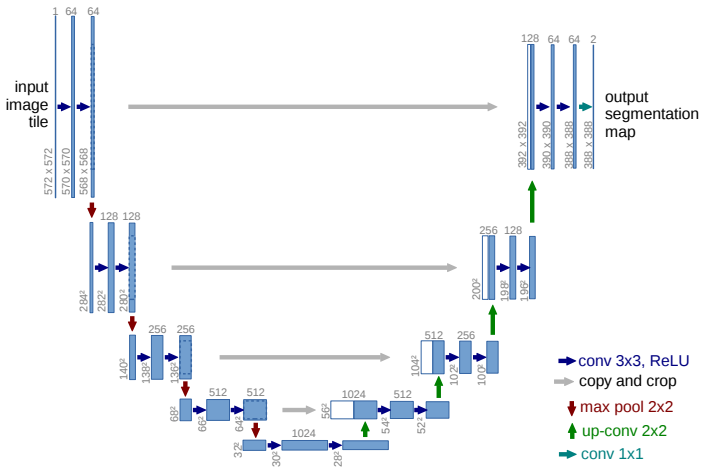

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

**Additional U-Net Model Variation:** unet10
I 've decided to try one more model: unet10, unet with max unpooling.
The difference between U-Net 10 and U-Net 11 is that in U-Net 10, I use return_indices for nn.MaxUnpool2d, similarly to how it was used in RegNet. For U-Net 11, I do not use return_indices according to Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015. .

So I'm comparing 4 models in total.

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
    self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 128 -> 64

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

    # Bottleneck
    self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(True),
        nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
        )

    # Decoder (upsampling)
    self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # nn.ReLU(True),
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )

    self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )

    self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 128 -> 256
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
    )


  def forward(self, x):
    # encoder
    e0 = self.enc_conv0(x)
    p0, ind0 = self.pool0(e0)
    e1 = self.enc_conv1(p0)
    p1 , ind1 = self.pool1(e1)
    e2 = self.enc_conv2(p1)
    p2, ind2 = self.pool2(e2)
    e3 = self.enc_conv3(p2)
    p3, ind3 = self.pool3(e3)

    # Bottleneck
    b = self.bottleneck_conv(p3)

    # decoder
    d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b, ind3)], 1))
    d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0, ind2)], 1))
    d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1, ind1)], 1))
    d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2, ind0)], 1))

    return d3


In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet10_bce = UNet().to(device)

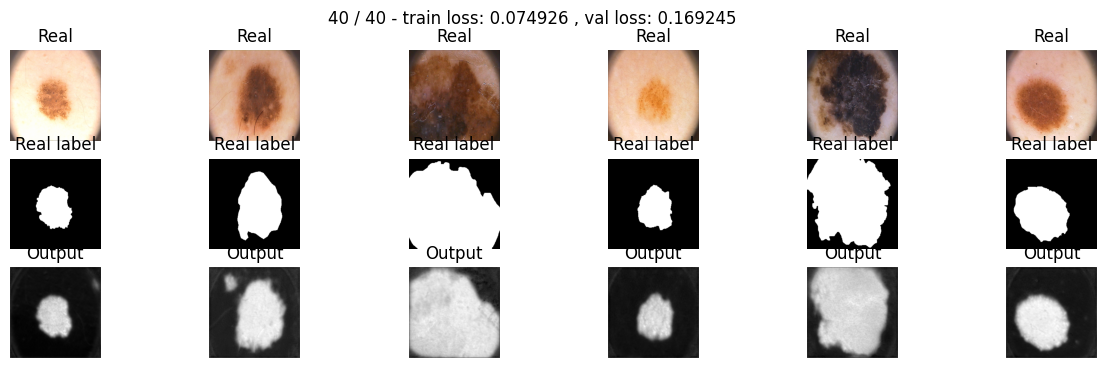

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model_unet10_bce.parameters(), lr=0.0001)
history_unet10_bce = train(model_unet10_bce, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
unet10_bce_scores = []
unet10_bce_scores.append(score_model(model_unet10_bce, iou_pytorch, data_tr))
unet10_bce_scores.append(score_model(model_unet10_bce, iou_pytorch, data_val))
unet10_bce_scores.append(score_model(model_unet10_bce, iou_pytorch, data_ts))
models_scores_per_loss['unet10\ntrain/val/test']['bce'] = unet10_bce_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet10_bce")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │
│         │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │
├─────────┼──────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┤
│ dice    │ [0.8469999879598618, 0.75, 0.695999950170517]                │ nan                                                          │
├─────────┼───────────────────────

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet10_bce.pkl'

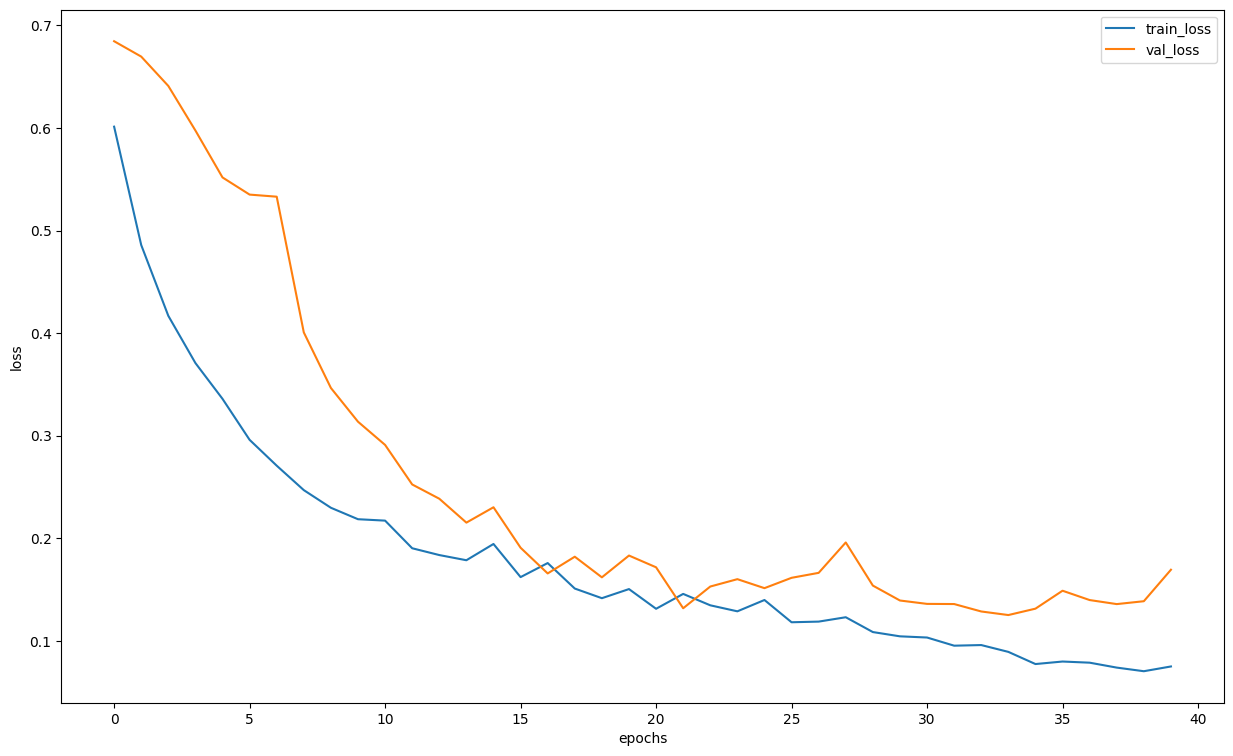

'/content/gdrive/MyDrive/hw5_history_unet10_bce.pkl'

In [ ]:
plot_loss_history(history_unet10_bce)
save_stats(history_unet10_bce, suffix="history_unet10_bce")

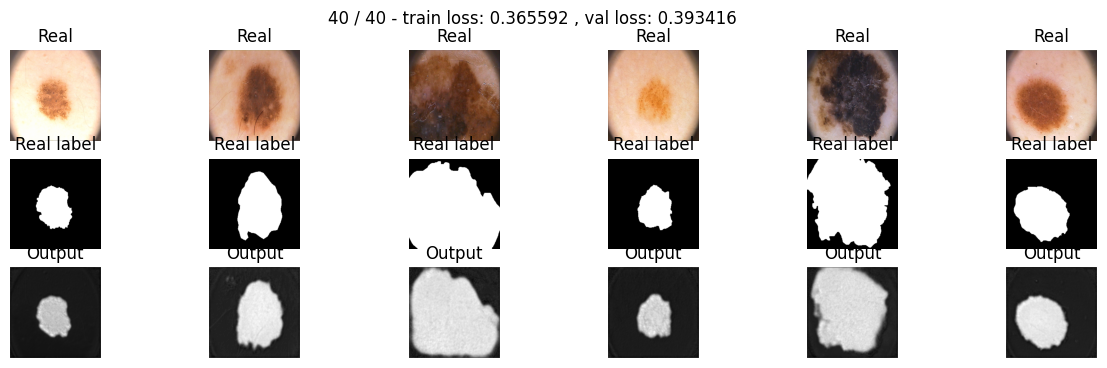

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet10_dice = UNet().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet10_dice.parameters(), lr=0.0001)
history_unet10_dice = train(model_unet10_dice, optim, dice_loss, max_epochs, data_tr, data_val)


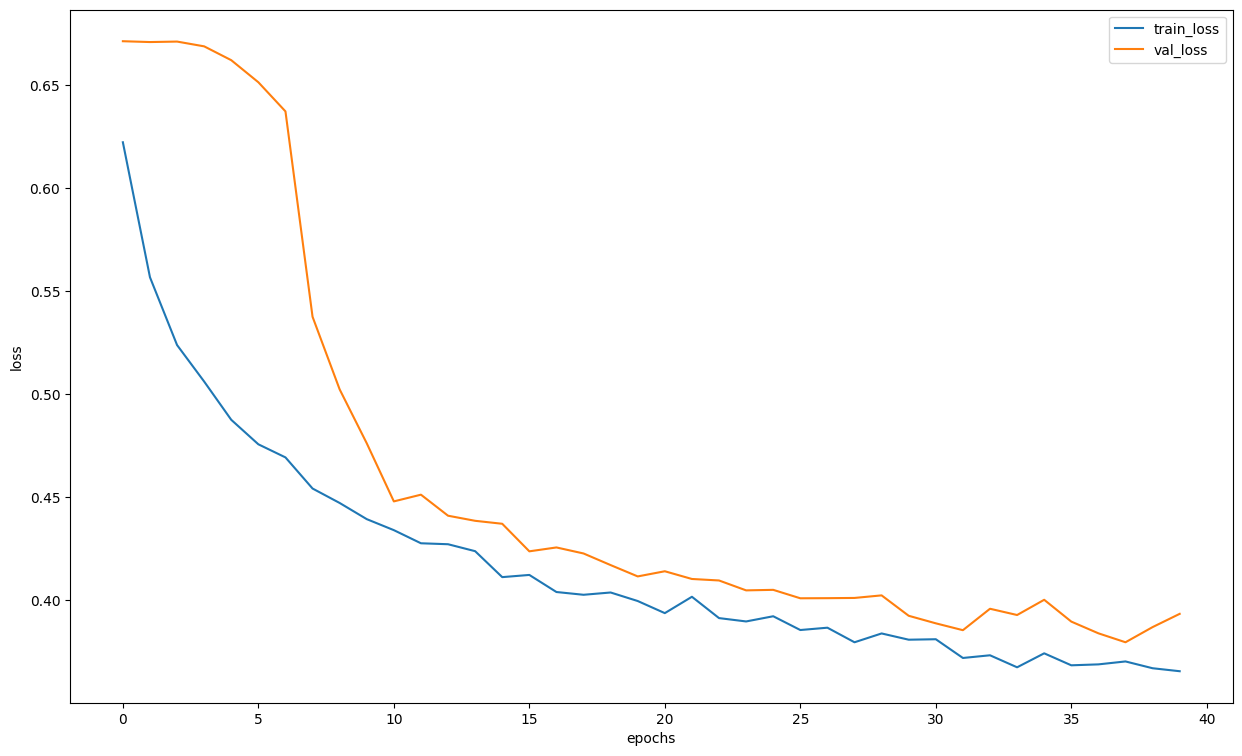

'/content/gdrive/MyDrive/hw5_history_unet10_dice.pkl'

In [ ]:
plot_loss_history(history_unet10_dice)
save_stats(history_unet10_dice, suffix="history_unet10_dice")

In [ ]:

unet10_dice_scores = []
unet10_dice_scores.append(score_model(model_unet10_dice, iou_pytorch, data_tr))
unet10_dice_scores.append(score_model(model_unet10_dice, iou_pytorch, data_val))
unet10_dice_scores.append(score_model(model_unet10_dice, iou_pytorch, data_ts))
models_scores_per_loss['unet10\ntrain/val/test']['dice'] = unet10_dice_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet10_dice")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │
│         │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │
├─────────┼──────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┤
│ dice    │ [0.8469999879598618, 0.75, 0.695999950170517]                │ [0.878000020980835, 0.7639999389648438, 0.6800000071525574]  │
├─────────┼───────────────────────

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet10_dice.pkl'

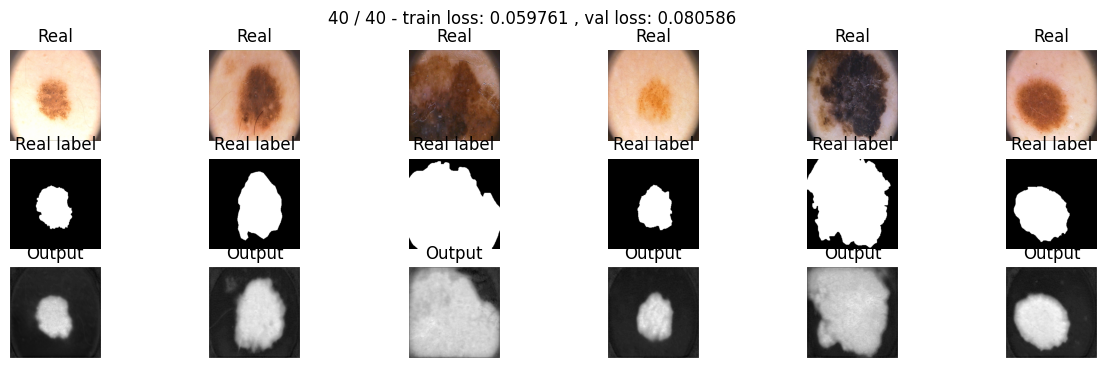

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet10_focal = UNet().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet10_focal.parameters(), lr=0.0001)
history_unet10_focal = train(model_unet10_focal, optim, focal_loss, max_epochs, data_tr, data_val)

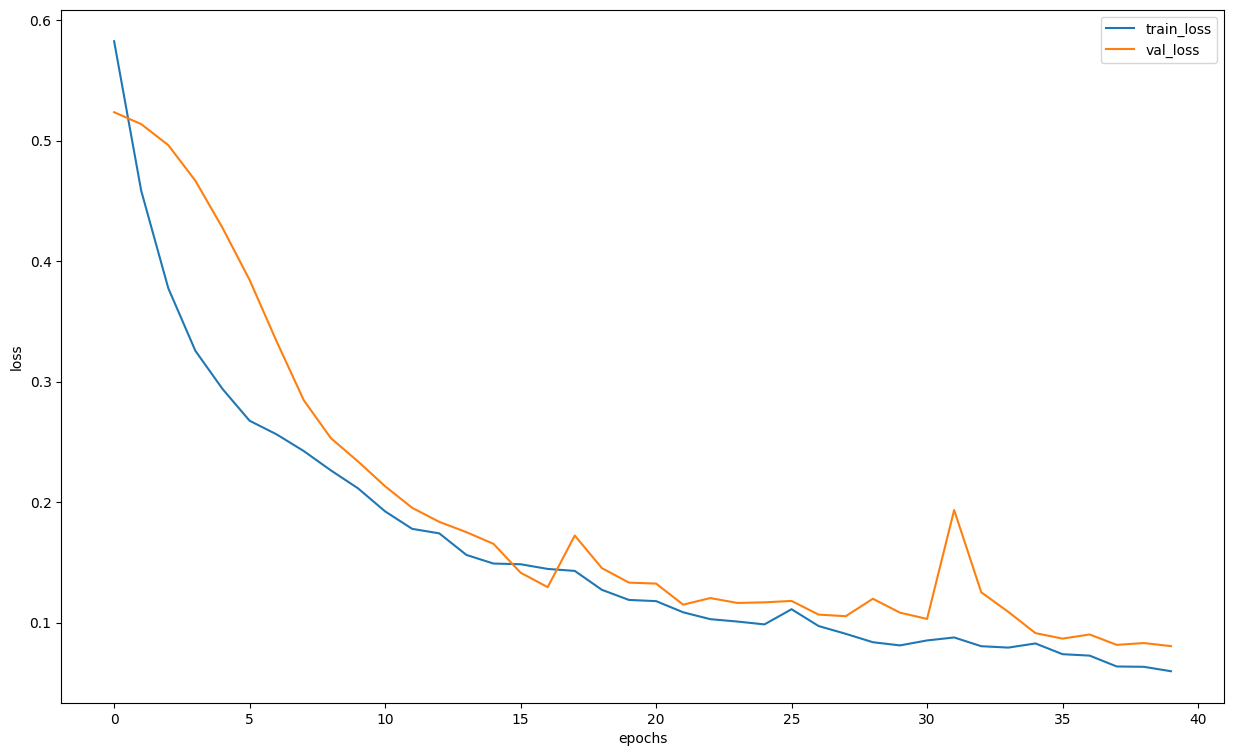

'/content/gdrive/MyDrive/hw5_history_unet10_focal.pkl'

In [ ]:
plot_loss_history(history_unet10_focal)
save_stats(history_unet10_focal, suffix="history_unet10_focal")

In [ ]:

unet10_focal_scores = []
unet10_focal_scores.append(score_model(model_unet10_focal, iou_pytorch, data_tr))
unet10_focal_scores.append(score_model(model_unet10_focal, iou_pytorch, data_val))
unet10_focal_scores.append(score_model(model_unet10_focal, iou_pytorch, data_ts))
models_scores_per_loss['unet10\ntrain/val/test']['focal'] = unet10_focal_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet10_focal")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │
│         │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │
├─────────┼──────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┤
│ dice    │ [0.8469999879598618, 0.75, 0.695999950170517]                │ [0.878000020980835, 0.7639999389648438, 0.6800000071525574]  │
├─────────┼───────────────────────

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet10_focal.pkl'

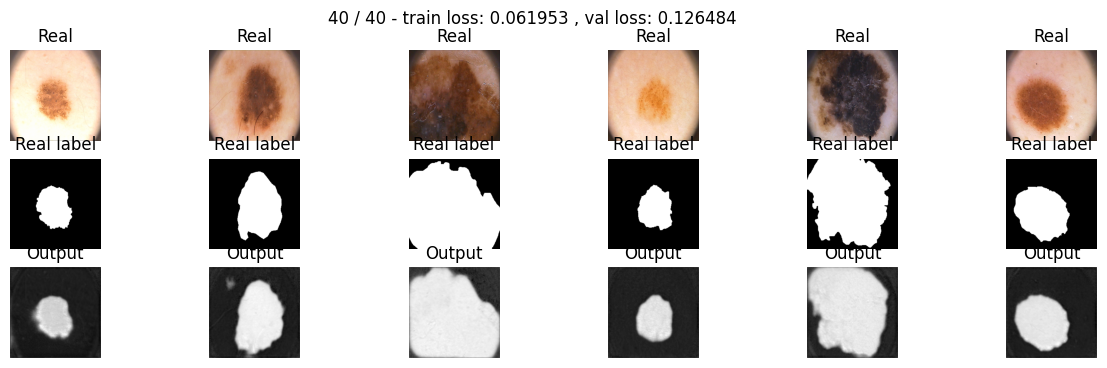

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_net10_tversky = UNet().to(device)
max_epochs = 40
optim = torch.optim.Adam(model_net10_tversky.parameters(), lr=0.0001)
history_unet10_tversky = train(model_net10_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

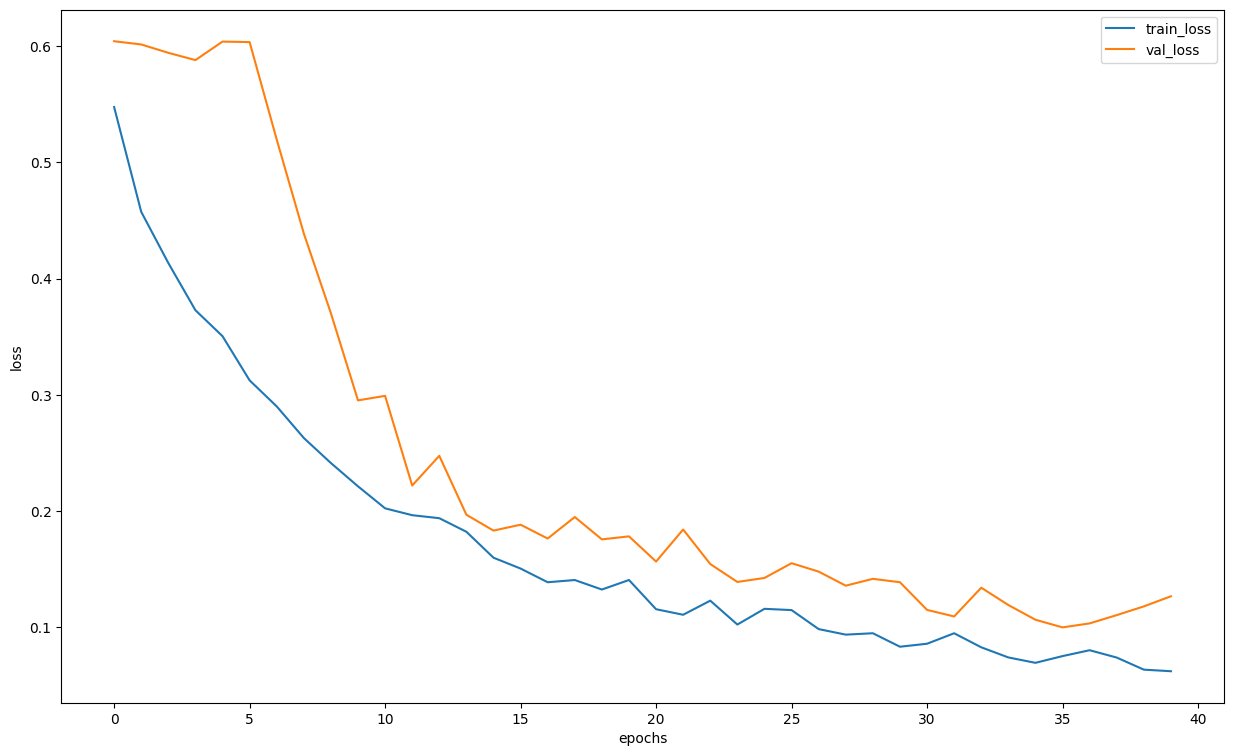

'/content/gdrive/MyDrive/hw5_history_unet10_tversky.pkl'

In [ ]:
plot_loss_history(history_unet10_tversky)
save_stats(history_unet10_tversky, suffix="history_unet10_tversky")

In [ ]:
unet10_tversky_scores = []
unet10_tversky_scores.append(score_model(model_net10_tversky, iou_pytorch, data_tr))
unet10_tversky_scores.append(score_model(model_net10_tversky, iou_pytorch, data_val))
unet10_tversky_scores.append(score_model(model_net10_tversky, iou_pytorch, data_ts))
models_scores_per_loss['unet10\ntrain/val/test']['tversky'] = unet10_tversky_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet10_tversky")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │
│         │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │
├─────────┼──────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────┤
│ dice    │ [0.8469999879598618, 0.75, 0.695999950170517]                │ [0.878000020980835, 0.7639999389648438, 0.6800000071525574]  │
├─────────┼───────────────────────

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet10_tversky.pkl'

In [ ]:
models_losses_per_loss['unet10']['bce'] = history_unet10_bce
models_losses_per_loss['unet10']['dice'] = history_unet10_dice
models_losses_per_loss['unet10']['focal'] = history_unet10_focal
models_losses_per_loss['unet10']['tversky'] = history_unet10_tversky

In [ ]:
class UNet11(nn.Module):
  def __init__(self):
    super().__init__()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')


    # Encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )

    # Bottleneck
    self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(True),
        nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
        )

    # Decoder (upsampling)
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )

    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )

    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
    )


  def forward(self, x):
    # encoder
    e0 = self.enc_conv0(x)
    p0 = self.pool(e0)
    e1 = self.enc_conv1(p0)
    p1 = self.pool(e1)
    e2 = self.enc_conv2(p1)
    p2 = self.pool(e2)
    e3 = self.enc_conv3(p2)
    p3 = self.pool(e3)

    # Bottleneck
    b = self.bottleneck_conv(p3)

    # decoder
    d0 = self.dec_conv0(torch.cat([e3, self.upsample(b)], 1))
    d1 = self.dec_conv1(torch.cat([e2, self.upsample(d0)], 1))
    d2 = self.dec_conv2(torch.cat([e1, self.upsample(d1)], 1))
    d3 = self.dec_conv3(torch.cat([e0, self.upsample(d2)], 1))

    return d3


In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet11_bce = UNet11().to(device)

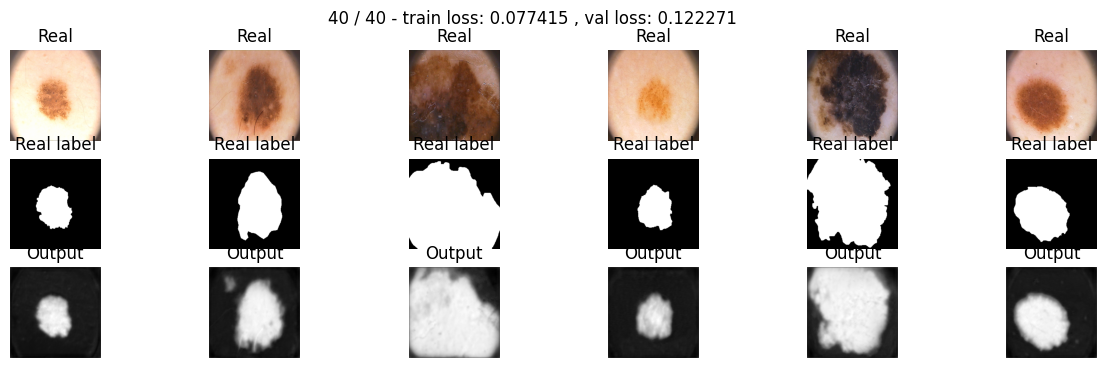

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model_unet11_bce.parameters(), lr=0.0001)
history_unet11_bce = train(model_unet11_bce, optim, bce_loss, max_epochs, data_tr, data_val)

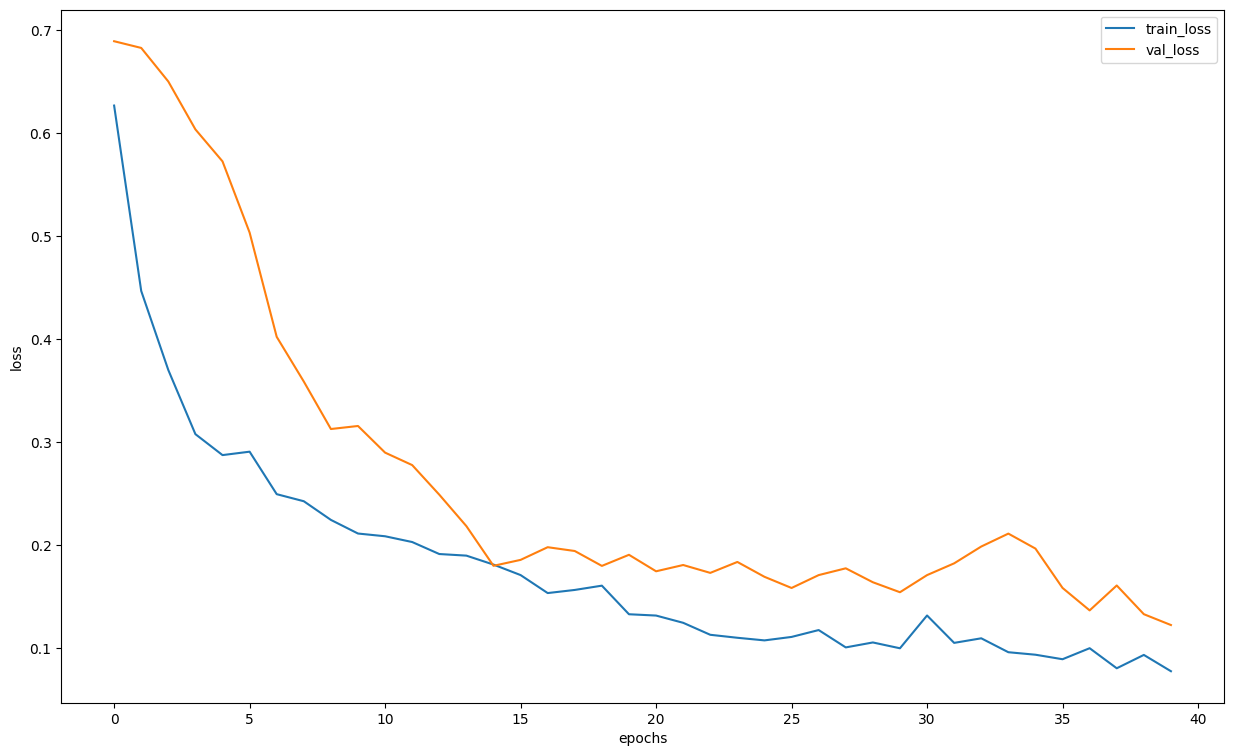

'/content/gdrive/MyDrive/hw5_history_unet11_bce.pkl'

In [ ]:
plot_loss_history(history_unet11_bce)

save_stats(history_unet11_bce, suffix="history_unet11_bce")

In [ ]:
unet11_bce_scores = []
unet11_bce_scores.append(score_model(model_unet11_bce, iou_pytorch, data_tr))
unet11_bce_scores.append(score_model(model_unet11_bce, iou_pytorch, data_val))
unet11_bce_scores.append(score_model(model_unet11_bce, iou_pytorch, data_ts))
models_scores_per_loss['unet11\ntrain/val/test']['bce'] = unet11_bce_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet11_bce")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │ [0.9189999997615814, 0.8220000267028809, 0.725999981164932

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet11_bce.pkl'

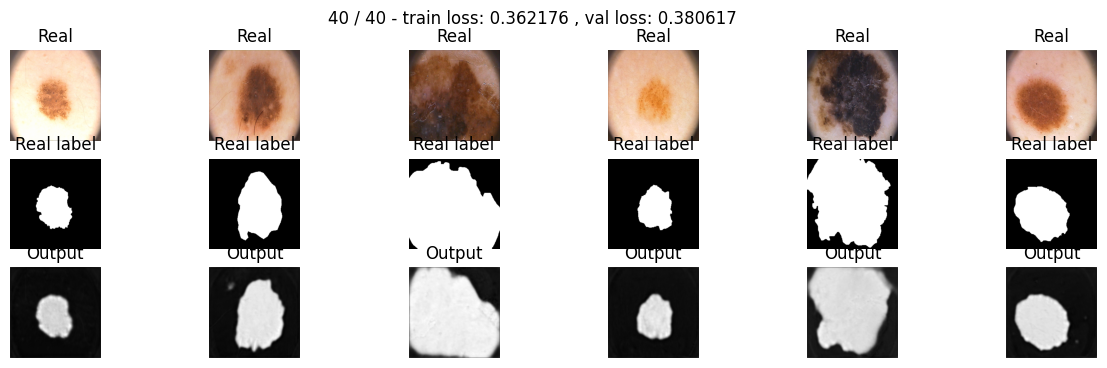

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet11_dice = UNet11().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet11_dice.parameters(), lr=0.0001)
history_unet11_dice = train(model_unet11_dice, optim, dice_loss, max_epochs, data_tr, data_val)


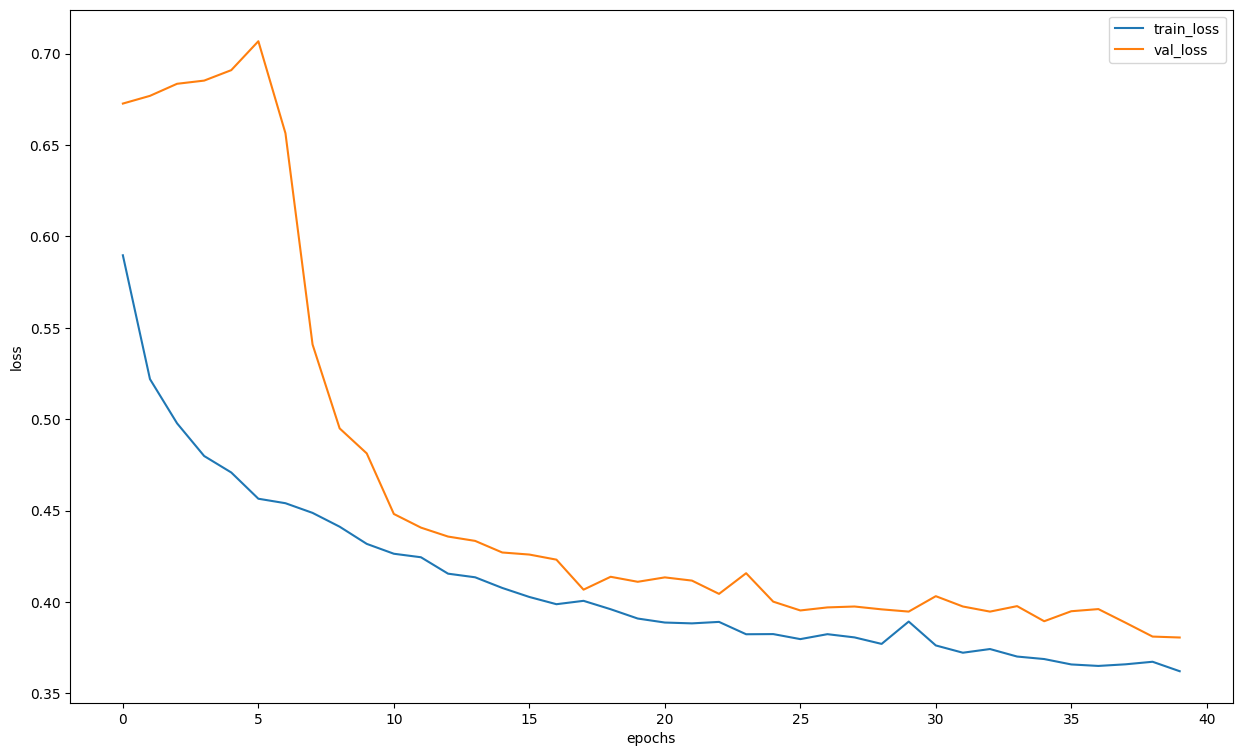

'/content/gdrive/MyDrive/hw5_history_unet11_dice.pkl'

In [ ]:
plot_loss_history(history_unet11_dice)
save_stats(history_unet11_dice, suffix="history_unet11_dice")

In [ ]:
unet11_dice_scores = []
unet11_dice_scores.append(score_model(model_unet11_dice, iou_pytorch, data_tr))
unet11_dice_scores.append(score_model(model_unet11_dice, iou_pytorch, data_val))
unet11_dice_scores.append(score_model(model_unet11_dice, iou_pytorch, data_ts))
models_scores_per_loss['unet11\ntrain/val/test']['dice'] = unet11_dice_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet11_dice")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │ [0.9189999997615814, 0.8220000267028809, 0.725999981164932

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet11_dice.pkl'

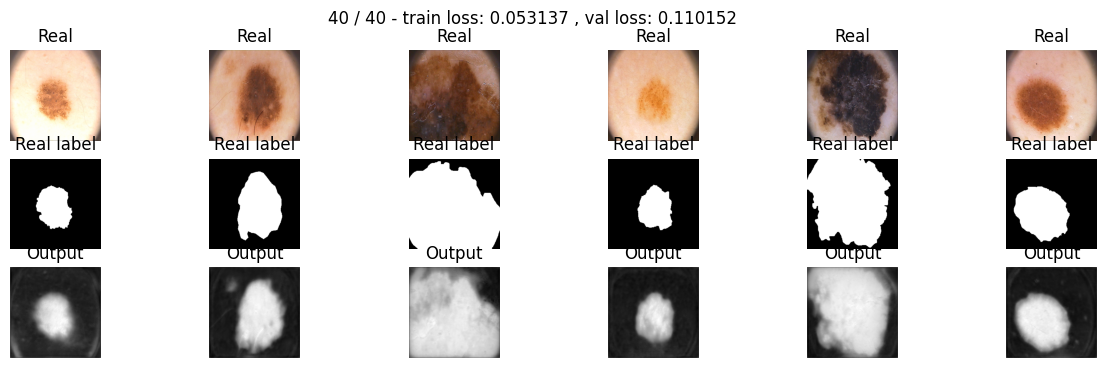

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet11_focal = UNet11().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet11_focal.parameters(), lr=0.0001)
history_unet11_focal = train(model_unet11_focal, optim, focal_loss, max_epochs, data_tr, data_val)


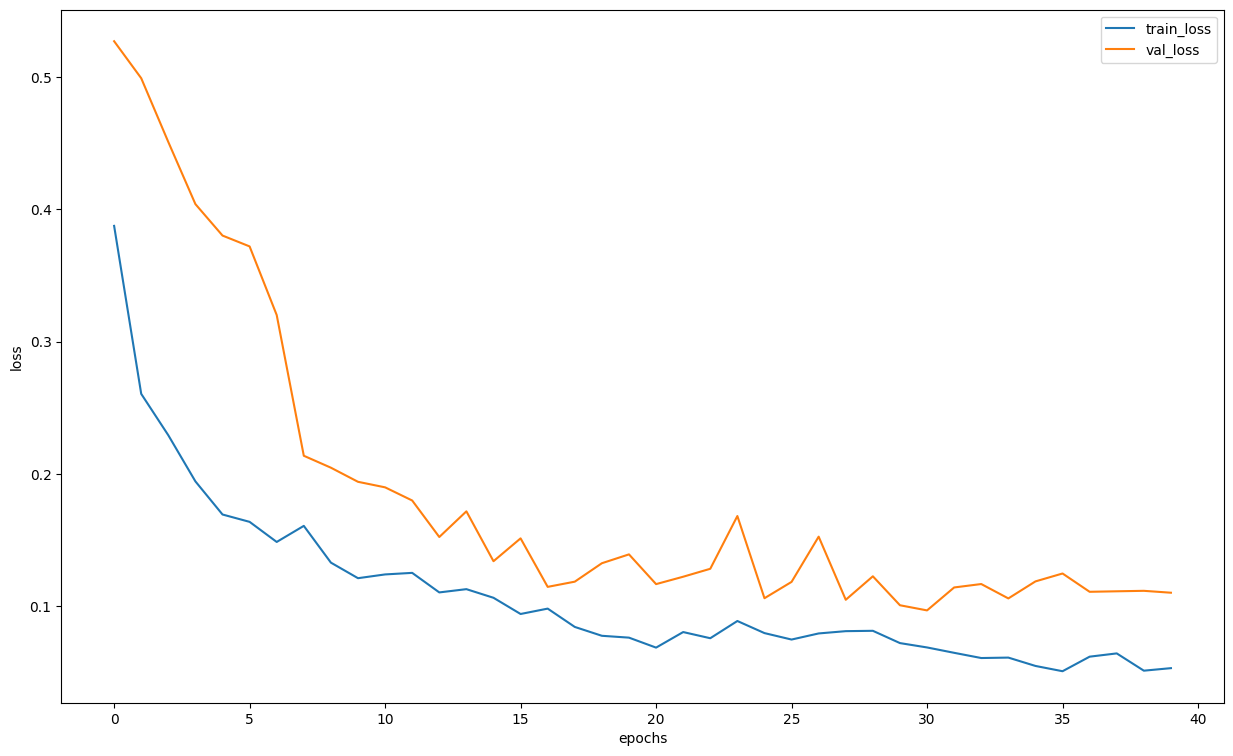

'/content/gdrive/MyDrive/hw5_history_unet11_focal.pkl'

In [ ]:
plot_loss_history(history_unet11_focal)
save_stats(history_unet11_focal, suffix="history_unet11_focal")

In [ ]:
unet11_focal_scores = []
unet11_focal_scores.append(score_model(model_unet11_focal, iou_pytorch, data_tr))
unet11_focal_scores.append(score_model(model_unet11_focal, iou_pytorch, data_val))
unet11_focal_scores.append(score_model(model_unet11_focal, iou_pytorch, data_ts))
models_scores_per_loss['unet11\ntrain/val/test']['focal'] = unet11_focal_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet11_focal")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │ [0.9189999997615814, 0.8220000267028809, 0.725999981164932

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet11_focal.pkl'

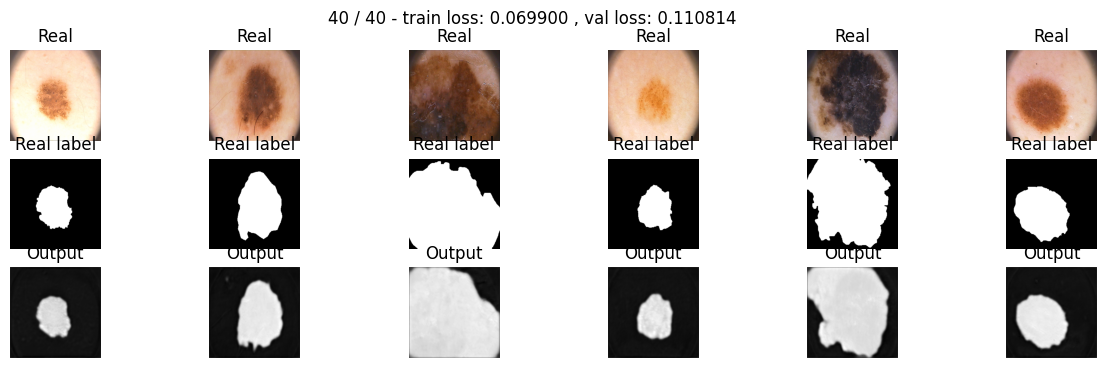

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_net11_tversky = UNet11().to(device)
max_epochs = 40
optim = torch.optim.Adam(model_net11_tversky.parameters(), lr=0.0001)
history_unet11_tversky = train(model_net11_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

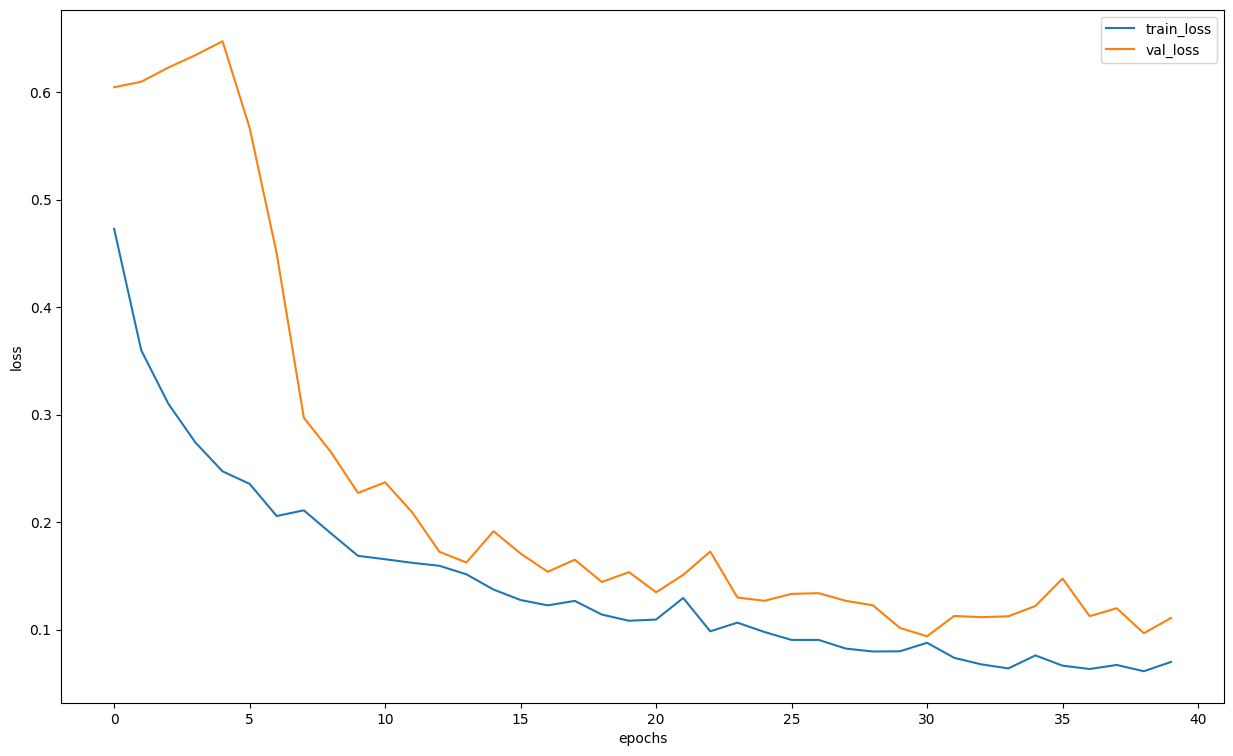

'/content/gdrive/MyDrive/hw5_history_unet11_tversky.pkl'

In [ ]:
plot_loss_history(history_unet11_tversky)
save_stats(history_unet11_tversky, suffix="history_unet11_tversky")

In [ ]:
unet11_tversky_scores = []
unet11_tversky_scores.append(score_model(model_net11_tversky, iou_pytorch, data_tr))
unet11_tversky_scores.append(score_model(model_net11_tversky, iou_pytorch, data_val))
unet11_tversky_scores.append(score_model(model_net11_tversky, iou_pytorch, data_ts))
models_scores_per_loss['unet11\ntrain/val/test']['tversky'] = unet11_tversky_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet11_tversky")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╡
│ bce     │ [0.896000012755394, 0.7800000011920929, 0.7060000002384186]  │ [0.9169999808073044, 0.7880000174045563, 0.7339999973773956] │ [0.9189999997615814, 0.8220000267028809, 0.725999981164932

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet11_tversky.pkl'

In [ ]:
models_losses_per_loss['unet11']['bce'] = history_unet11_bce
models_losses_per_loss['unet11']['dice'] = history_unet11_dice
models_losses_per_loss['unet11']['focal'] = history_unet11_focal
models_losses_per_loss['unet11']['tversky'] = history_unet11_tversky

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
    self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)

    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )
    self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
    )
    self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)

    # Bottleneck
    self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(True),
        nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True)
        )

    # Decoder (upsampling)
    self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True)
    )

    self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )

    self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
    )


  def forward(self, x):
    # encoder
    e0 = self.enc_conv0(x)
    p0 = self.pool0(e0)
    e1 = self.enc_conv1(p0)
    p1 = self.pool1(e1)
    e2 = self.enc_conv2(p1)
    p2 = self.pool2(e2)
    e3 = self.enc_conv3(p2)
    p3 = self.pool3(e3)

    # Bottleneck
    b = self.bottleneck_conv(p3)

    # decoder
    d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], 1))
    d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], 1))
    d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], 1))
    d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], 1))

    return d3

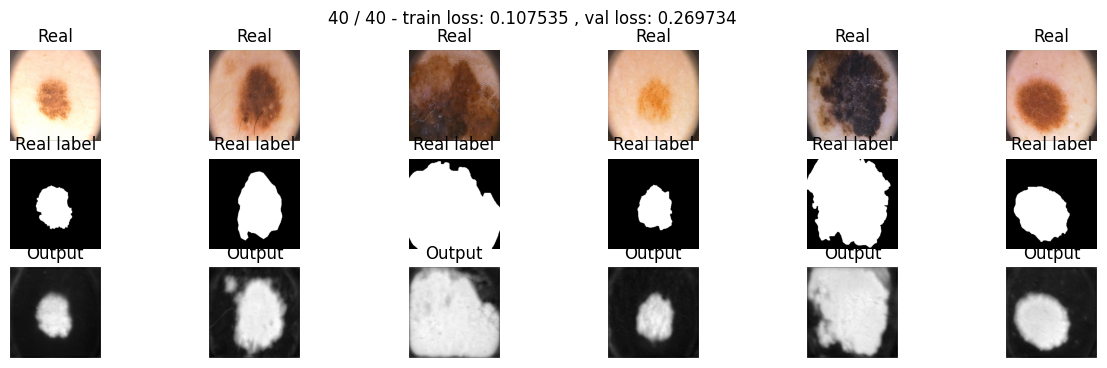

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet2_bce = UNet2().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet2_bce.parameters(), lr=0.0001)
history_unet2_bce = train(model_unet2_bce, optim, bce_loss, max_epochs, data_tr, data_val)


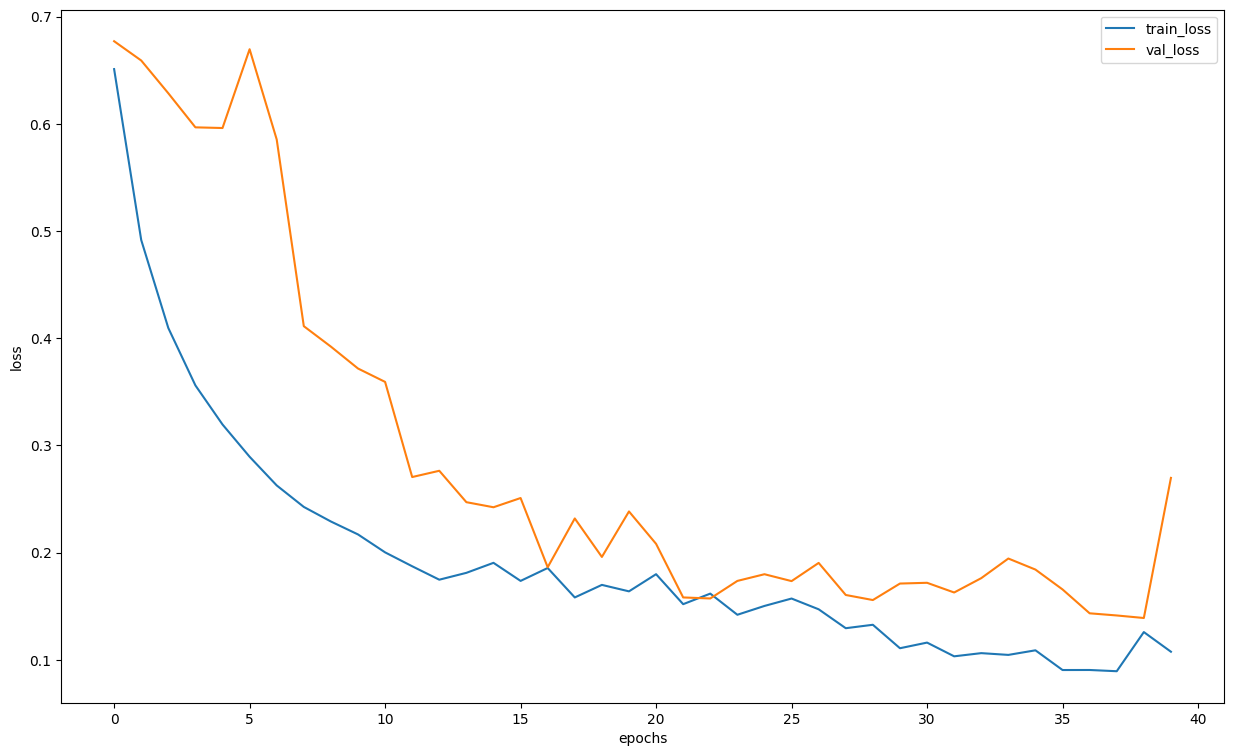

'/content/gdrive/MyDrive/hw5_history_unet2_bce.pkl'

In [ ]:
plot_loss_history(history_unet2_bce)
save_stats(history_unet2_bce, suffix="history_unet2_bce")

In [ ]:
unet2_bce_scores = []
unet2_bce_scores.append(score_model(model_unet11_bce, iou_pytorch, data_tr))
unet2_bce_scores.append(score_model(model_unet11_bce, iou_pytorch, data_val))
unet2_bce_scores.append(score_model(model_unet11_bce, iou_pytorch, data_ts))
models_scores_per_loss['unet2\ntrain/val/test']['bce'] = unet2_bce_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet2_bce")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │ unet2                                                        │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪════════

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet2_bce.pkl'

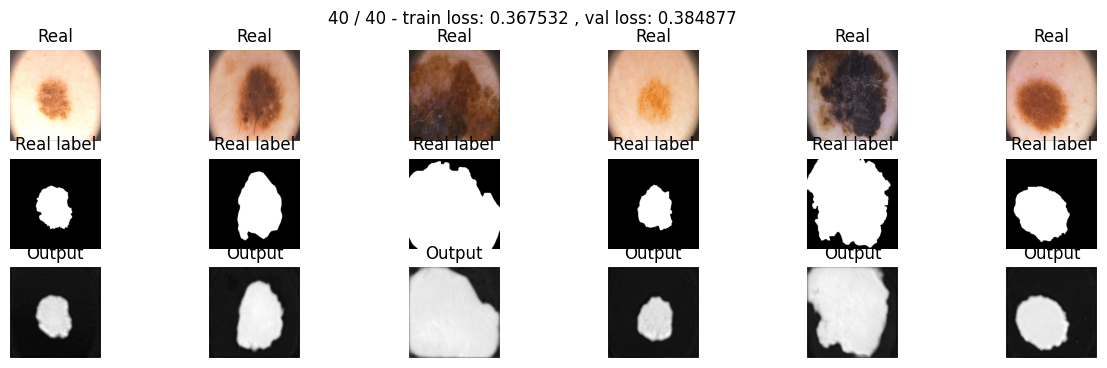

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet2_dice = UNet2().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet2_dice.parameters(), lr=0.0001)
history_unet2_dice = train(model_unet2_dice, optim, dice_loss, max_epochs, data_tr, data_val)


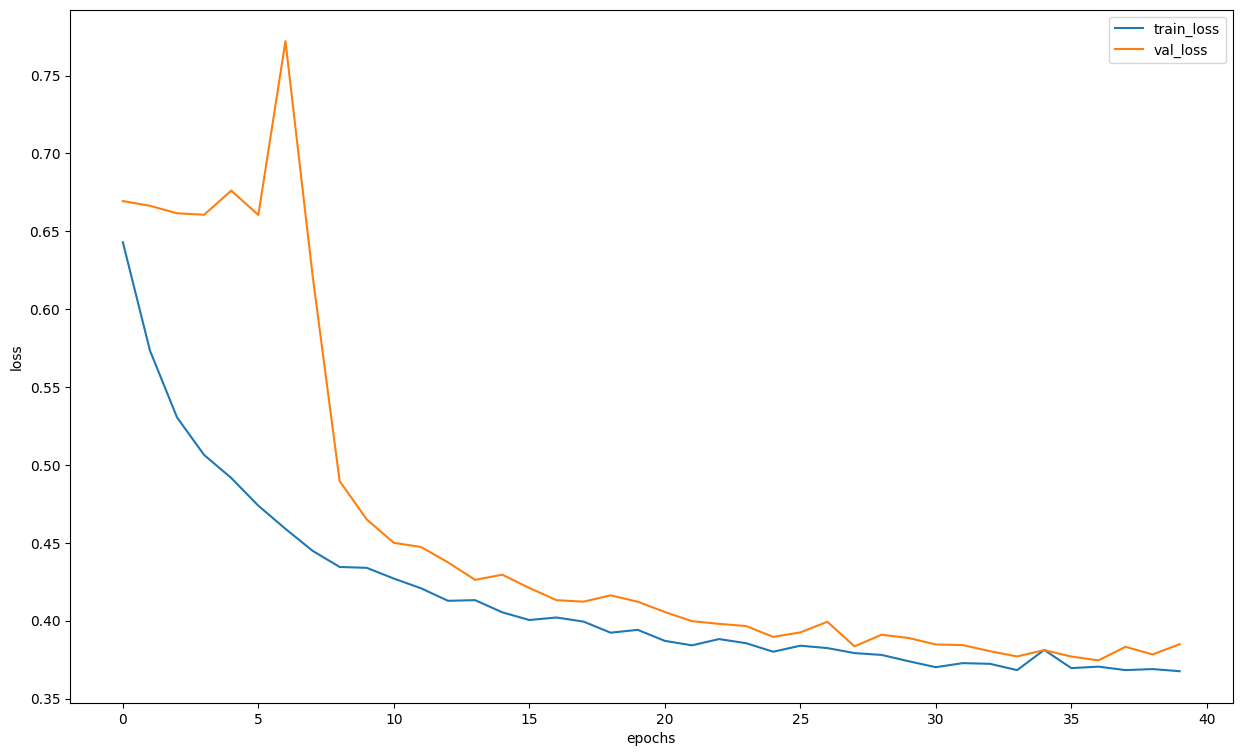

'/content/gdrive/MyDrive/hw5_history_unet2_dice.pkl'

In [ ]:
plot_loss_history(history_unet2_dice)
save_stats(history_unet2_dice, suffix="history_unet2_dice")

In [ ]:
unet2_dice_scores = []
unet2_dice_scores.append(score_model(model_unet2_dice, iou_pytorch, data_tr))
unet2_dice_scores.append(score_model(model_unet2_dice, iou_pytorch, data_val))
unet2_dice_scores.append(score_model(model_unet2_dice, iou_pytorch, data_ts))
models_scores_per_loss['unet2\ntrain/val/test']['dice'] = unet2_dice_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet2_dice")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │ unet2                                                        │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪════════

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet2_dice.pkl'

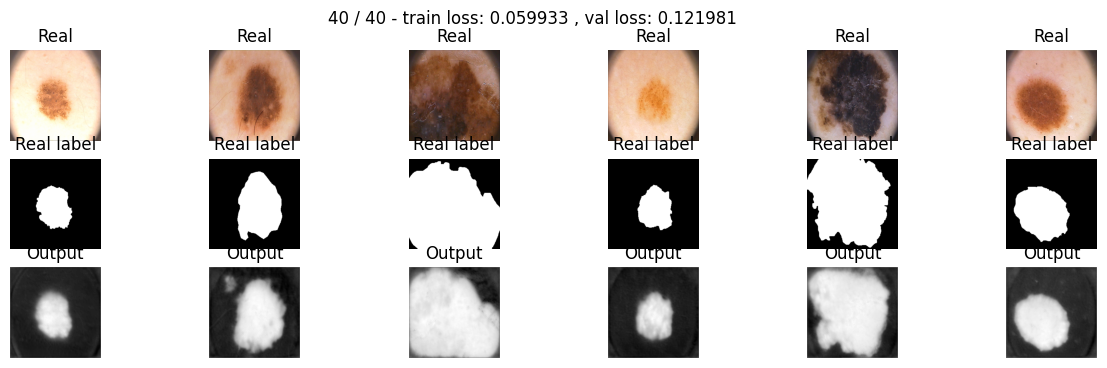

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_unet2_focal = UNet2().to(device)

max_epochs = 40
optim = torch.optim.Adam(model_unet2_focal.parameters(), lr=0.0001)
history_unet2_focal = train(model_unet2_focal, optim, focal_loss, max_epochs, data_tr, data_val)


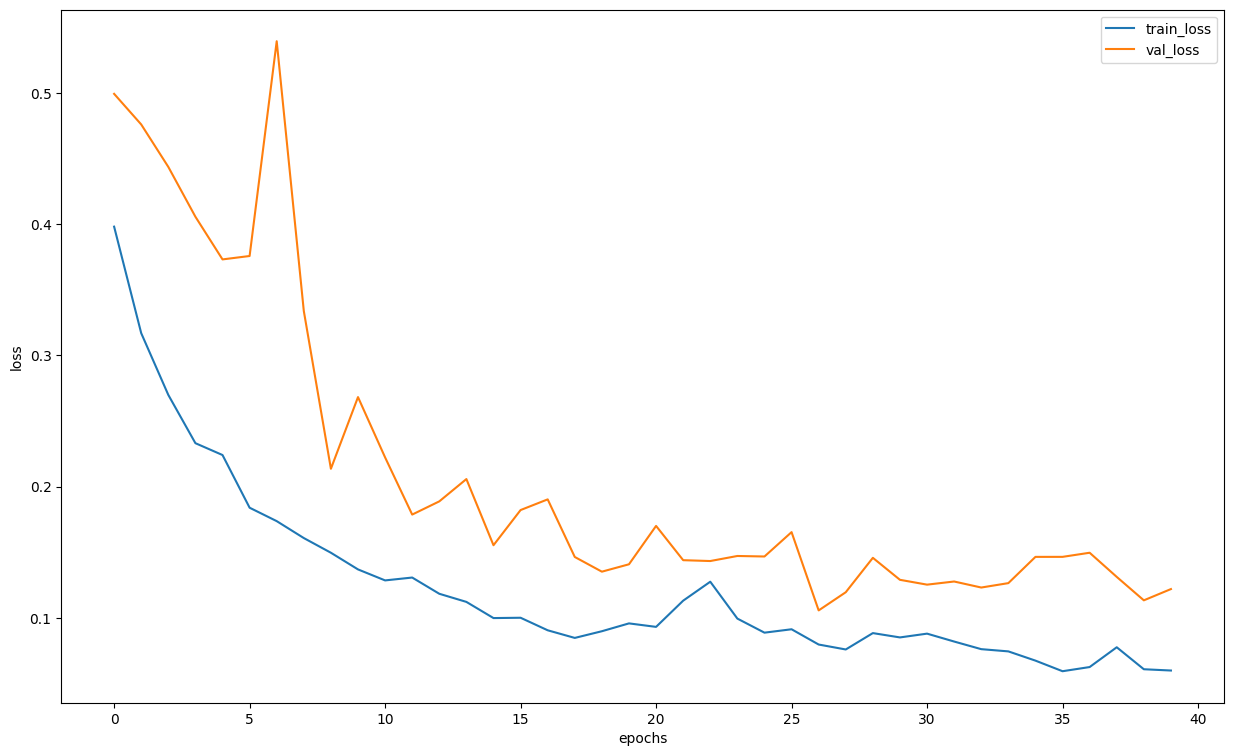

'/content/gdrive/MyDrive/hw5_history_unet2_focal.pkl'

In [ ]:
plot_loss_history(history_unet2_focal)
save_stats(history_unet2_focal, suffix="history_unet2_focal")

In [ ]:
unet2_focal_scores = []
unet2_focal_scores.append(score_model(model_unet2_focal, iou_pytorch, data_tr))
unet2_focal_scores.append(score_model(model_unet2_focal, iou_pytorch, data_val))
unet2_focal_scores.append(score_model(model_unet2_focal, iou_pytorch, data_ts))
models_scores_per_loss['unet2\ntrain/val/test']['focal'] = unet2_focal_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet2_focal")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │ unet2                                                        │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪════════

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet2_focal.pkl'

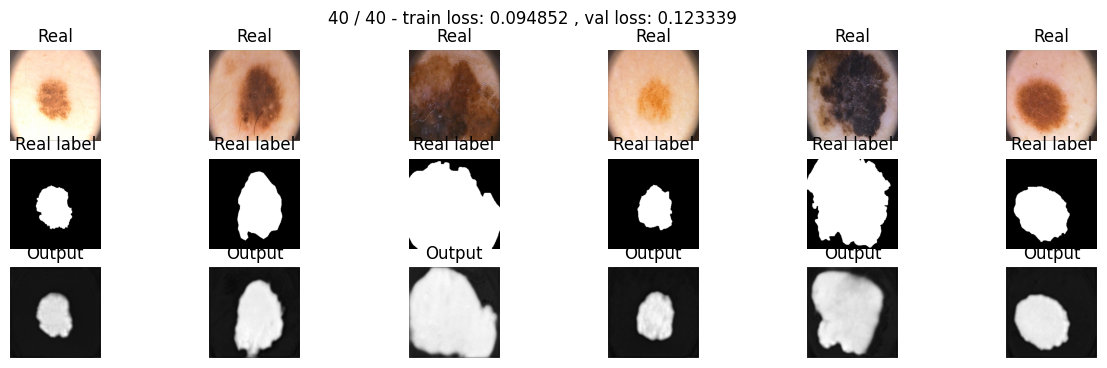

In [ ]:
# Clear the GPU memory cache
if torch.cuda.is_available():
  torch.cuda.empty_cache()

model_net2_tversky = UNet2().to(device)
max_epochs = 40
optim = torch.optim.Adam(model_net2_tversky.parameters(), lr=0.0001)
history_unet2_tversky = train(model_net2_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

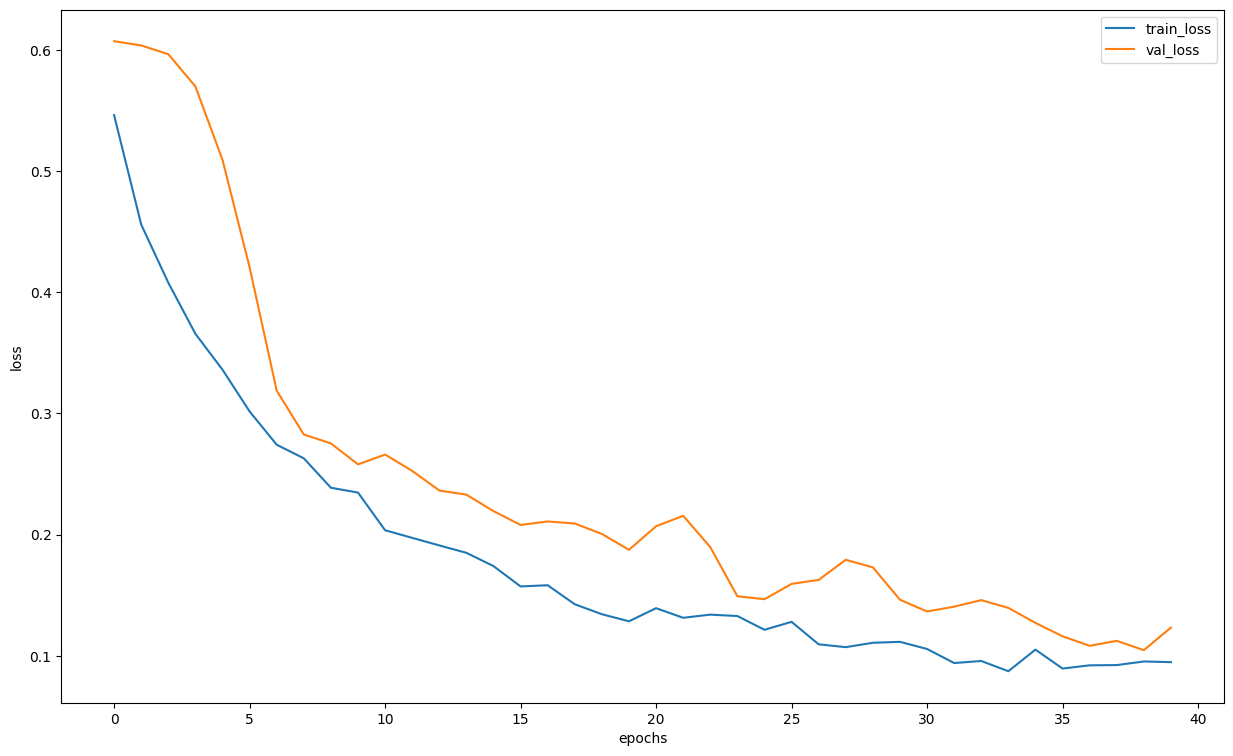

'/content/gdrive/MyDrive/hw5_history_unet2_tversky.pkl'

In [ ]:
plot_loss_history(history_unet2_tversky)
save_stats(history_unet2_tversky, suffix="history_unet2_tversky")

In [ ]:
unet2_tversky_scores = []
unet2_tversky_scores.append(score_model(model_net2_tversky, iou_pytorch, data_tr))
unet2_tversky_scores.append(score_model(model_net2_tversky, iou_pytorch, data_val))
unet2_tversky_scores.append(score_model(model_net2_tversky, iou_pytorch, data_ts))
models_scores_per_loss['unet2\ntrain/val/test']['tversky'] = unet2_tversky_scores


In [ ]:
print_model_scores_table(models_scores_per_loss)
save_stats(models_scores_per_loss, suffix="models_scores_per_loss_unet2_tversky")

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │ unet2                                                        │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪════════

'/content/gdrive/MyDrive/hw5_models_scores_per_loss_unet2_tversky.pkl'

In [ ]:
models_losses_per_loss['unet2']['bce'] = history_unet2_bce
models_losses_per_loss['unet2']['dice'] = history_unet2_dice
models_losses_per_loss['unet2']['focal'] = history_unet2_focal
models_losses_per_loss['unet2']['tversky'] = history_unet2_tversky

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [ ]:
import matplotlib.pyplot as plt

def compare_losses(model_losses, model_name):
    loss_names = list(model_losses.keys())

    # Create subplots for train and val losses
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    fig.suptitle(f'Comparison of Training and Validation Losses {model_name}')

    # Define colors for each loss type
    colors = ['b', 'g', 'r', 'c']  # Add or remove colors as needed/TBD replace with len(colors) = len(loss_names)

    for i, loss_name in enumerate(loss_names):
        # Extract training and validation losses for each model and loss
        losses = model_losses[loss_name]
        train_losses, val_losses = zip(*losses)

        # Plot training losses with different colors
        axs[0].plot(range(1, len(train_losses) + 1), train_losses, label=f'Train - {loss_name}', color=colors[i])

        # Plot validation losses with different colors
        axs[1].plot(range(1, len(val_losses) + 1), val_losses, label=f'Validation - {loss_name}', color=colors[i])

    # Set labels and titles
    axs[0].set_ylabel('Training Loss')
    axs[1].set_ylabel('Validation Loss')
    axs[1].set_xlabel('Epochs')

    # Add legends
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
model_names = ['regnet', 'unet10', 'unet11', 'unet2']
loss_names = ['bce', 'dice', 'focal', 'tversky']



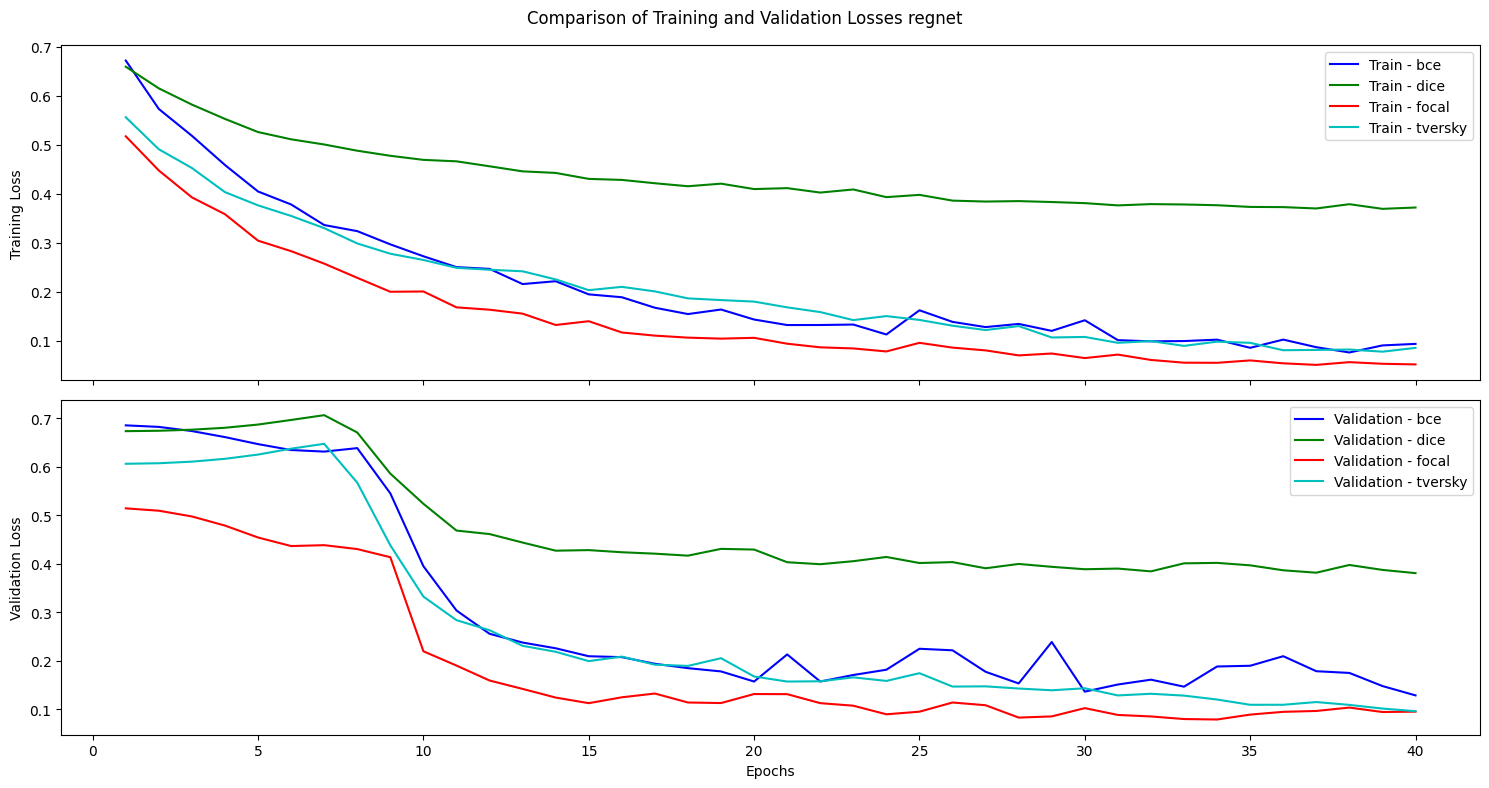

In [ ]:
compare_losses(models_losses_per_loss['regnet'], 'regnet')

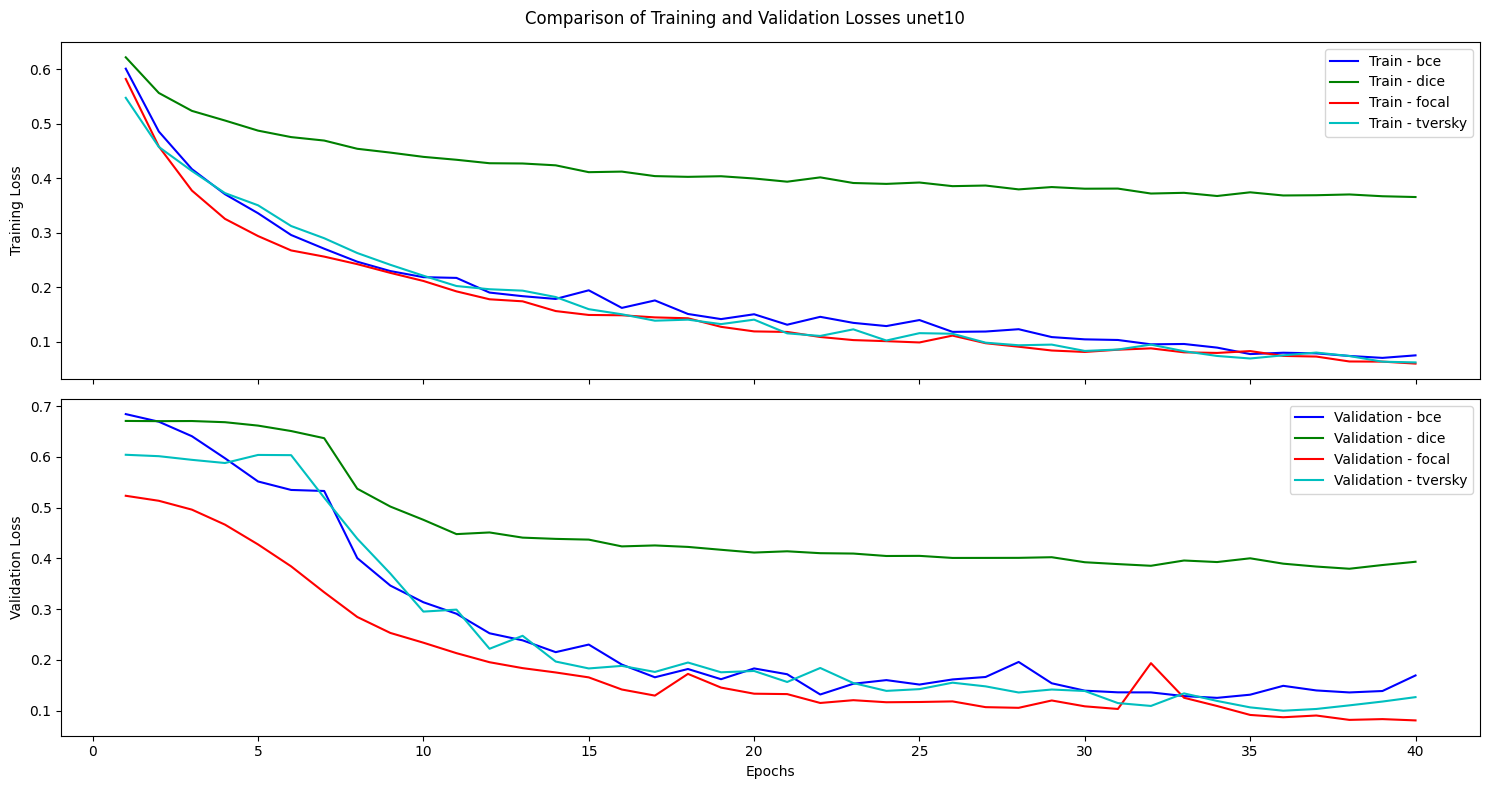

In [ ]:
compare_losses(models_losses_per_loss['unet10'], 'unet10')

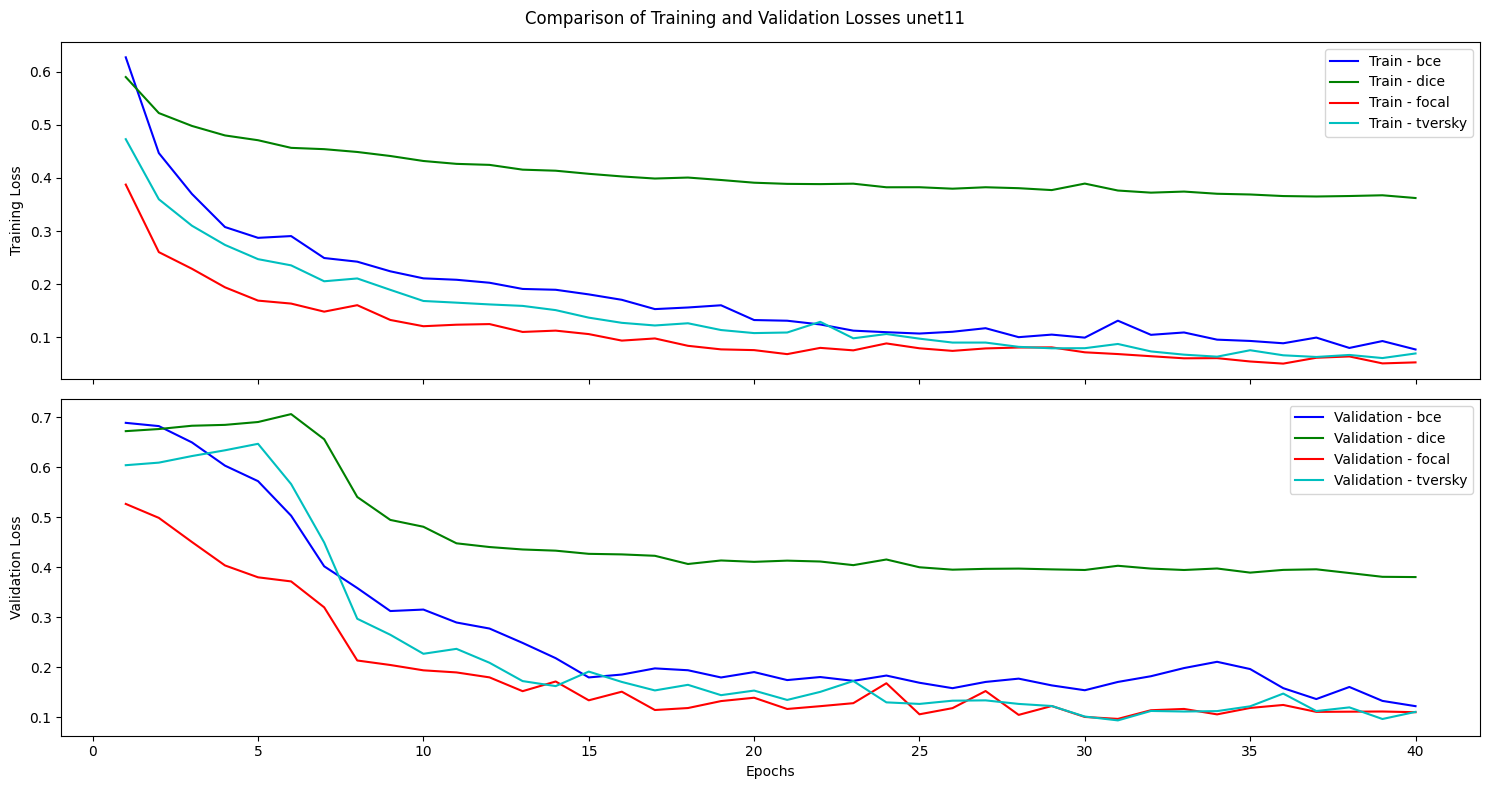

In [ ]:
compare_losses(models_losses_per_loss['unet11'], 'unet11')

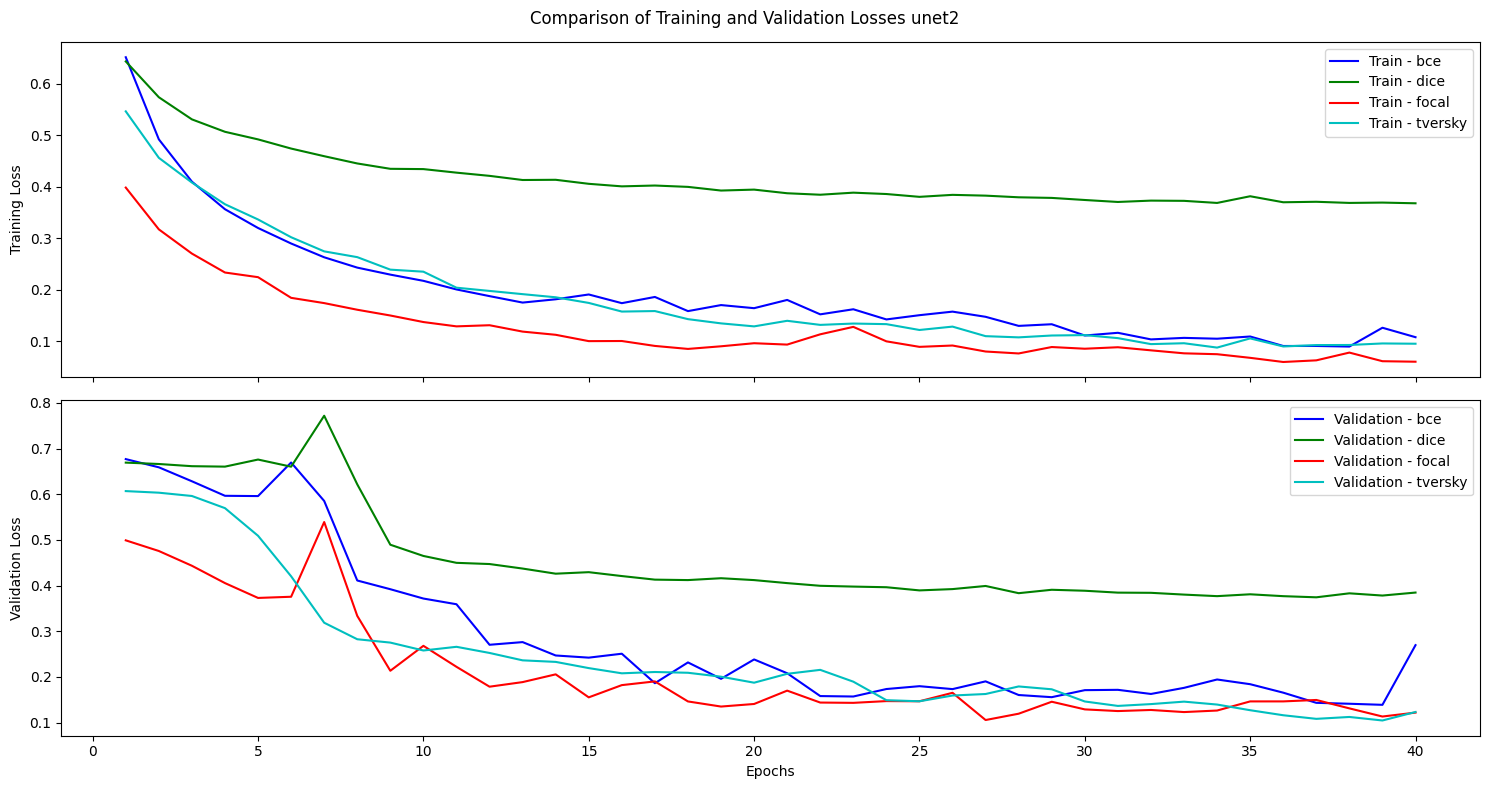

In [ ]:
compare_losses(models_losses_per_loss['unet2'], 'unet2')

**My observation:**  Tversky and focal losses provide better results for all the models than the other two losses.

In [ ]:
def compare_all_models_per_loss(models_losses, selected_loss, model_names, figsize=(12, 8)):
    # Initialize lists to store training and validation losses for the selected loss function
    train_losses = []
    val_losses = []

    # Iterate through model_names
    for model_name in model_names:
        if model_name in models_losses and selected_loss in models_losses[model_name]:
            # Extract training and validation losses for the selected loss function
            loss_values = models_losses[model_name][selected_loss]

            # Separate into training and validation lists
            train_loss_values, val_loss_values = zip(*loss_values)

            # Append to the overall lists
            train_losses.append((model_name, train_loss_values))
            val_losses.append((model_name, val_loss_values))

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot training losses
    for model_name, values in train_losses:
        ax1.plot(values, label=f'{model_name} (Train)')

    ax1.set_title(f'Training Losses for {selected_loss} across Models')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot validation losses
    for model_name, values in val_losses:
        ax2.plot(values, label=f'{model_name} (Validation)', linestyle='dashed')

    ax2.set_title(f'Validation Losses for {selected_loss} across Models')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

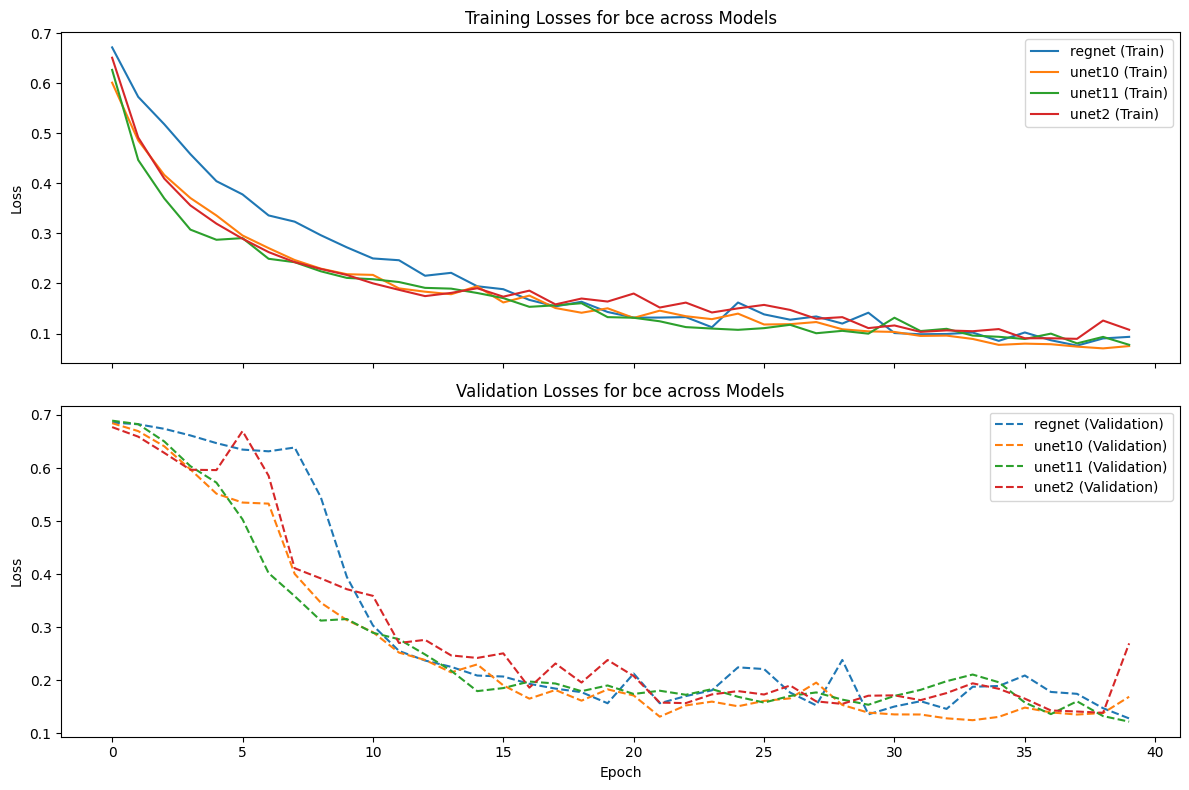

In [ ]:
compare_all_models_per_loss(models_losses_per_loss, 'bce', model_names)

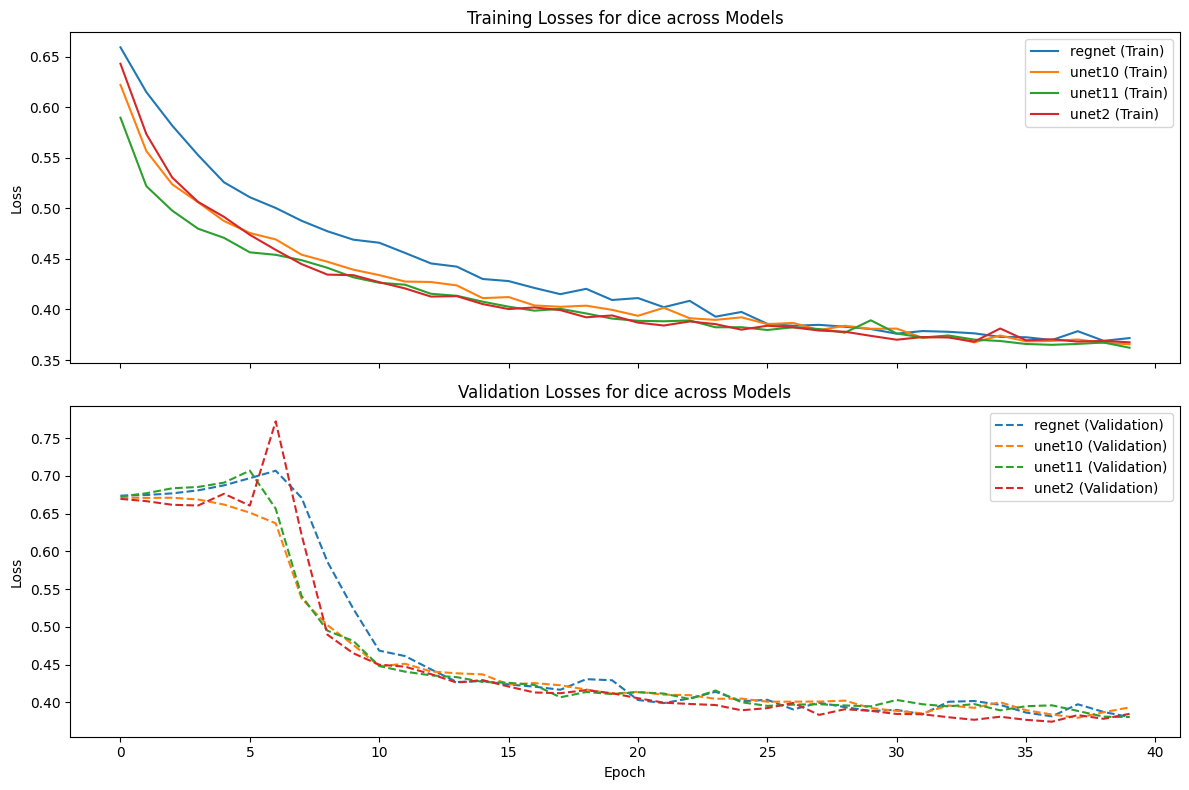

In [ ]:
compare_all_models_per_loss(models_losses_per_loss, 'dice', model_names)

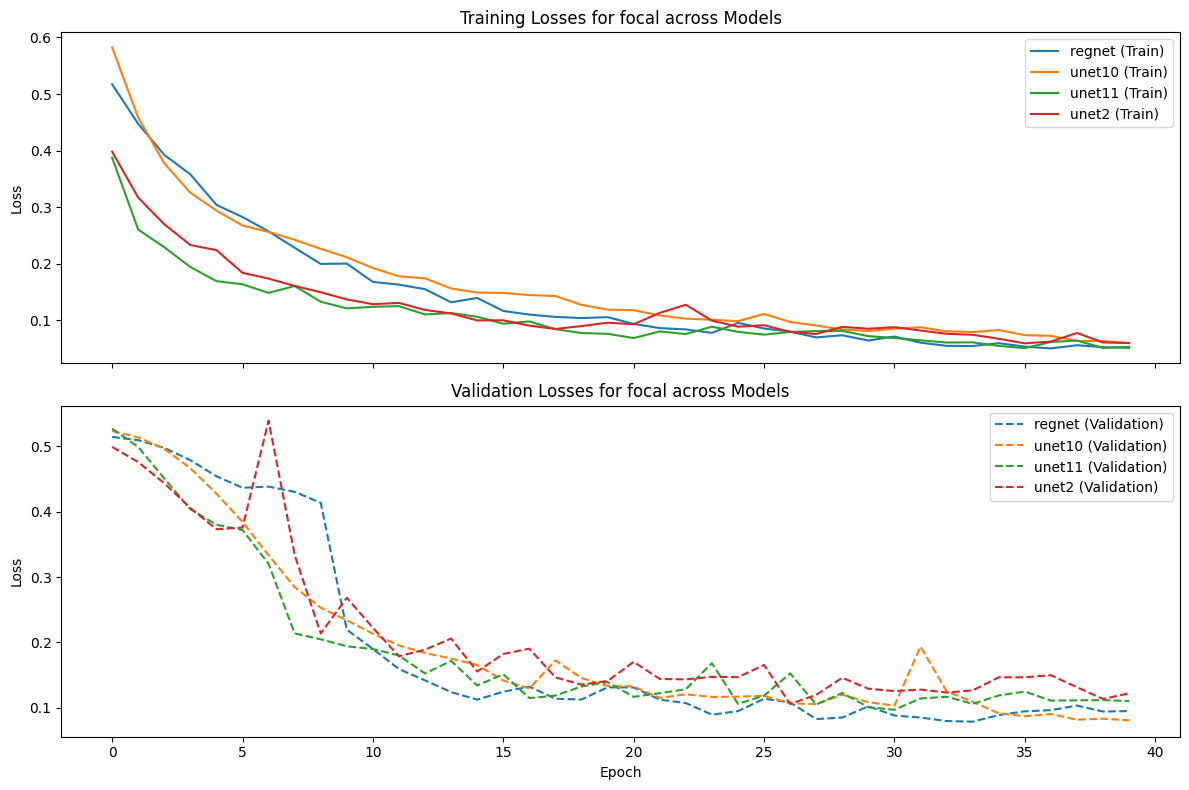

In [ ]:
compare_all_models_per_loss(models_losses_per_loss, 'focal', model_names)

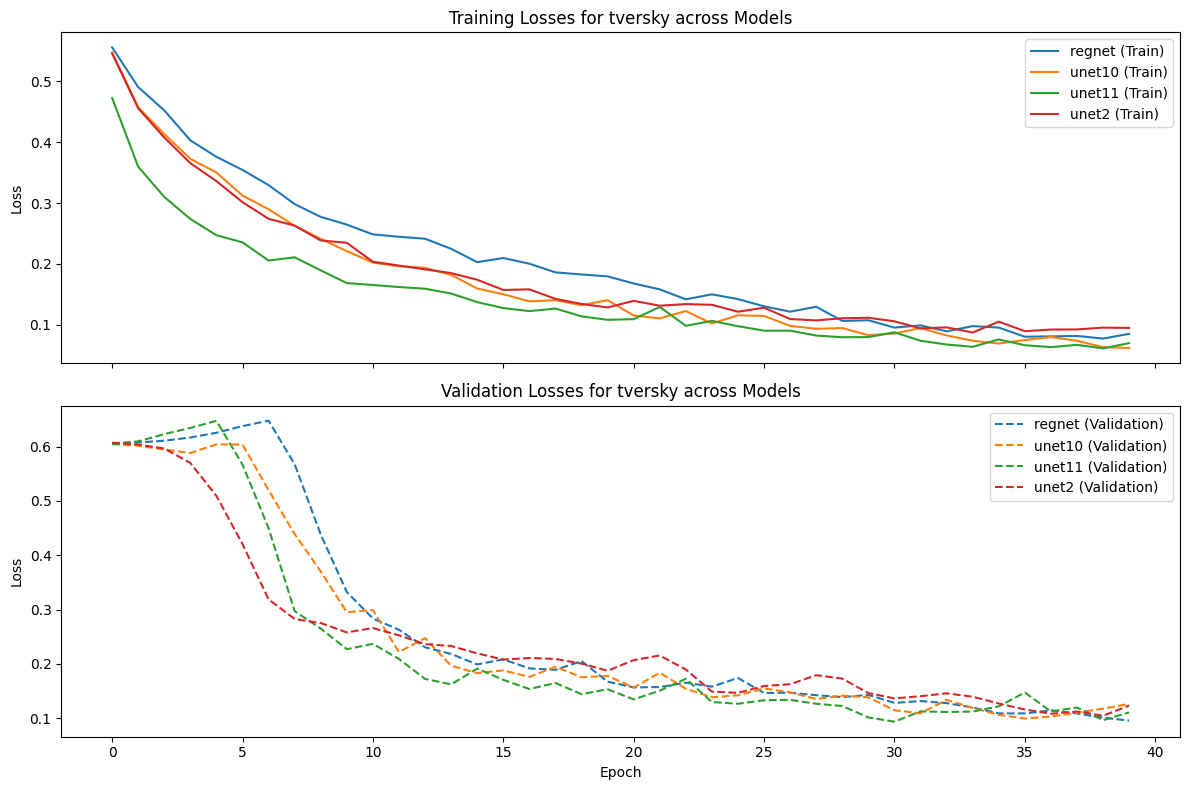

In [ ]:
compare_all_models_per_loss(models_losses_per_loss, 'tversky', model_names)

In [ ]:
def compare_selected_models_losses(models_losses, selected_model1, selected_loss1, selected_model2, selected_loss2, model_names, figsize=(12, 8)):
    # Function to extract losses for a selected model and loss
    def extract_losses(selected_model, selected_loss):
        if selected_model in models_losses and selected_loss in models_losses[selected_model]:
            loss_values = models_losses[selected_model][selected_loss]
            train_loss_values, val_loss_values = zip(*loss_values)
            return train_loss_values, val_loss_values
        else:
            return None, None

    # Extract losses for the selected models and losses
    train_losses_model1, val_losses_model1 = extract_losses(selected_model1, selected_loss1)
    train_losses_model2, val_losses_model2 = extract_losses(selected_model2, selected_loss2)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot training losses for selected_model1
    if train_losses_model1 is not None:
        ax1.plot(train_losses_model1, label=f'{selected_model1} ({selected_loss1} - Train)')

    # Plot validation losses for selected_model1
    if val_losses_model1 is not None:
        ax2.plot(val_losses_model1, label=f'{selected_model1} ({selected_loss1} - Validation)', linestyle='dashed')

    # Plot training losses for selected_model2
    if train_losses_model2 is not None:
        ax1.plot(train_losses_model2, label=f'{selected_model2} ({selected_loss2} - Train)')

    # Plot validation losses for selected_model2
    if val_losses_model2 is not None:
        ax2.plot(val_losses_model2, label=f'{selected_model2} ({selected_loss2} - Validation)', linestyle='dashed')

    # Set titles and labels
    ax1.set_title('Training Losses for Selected Models and Losses')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Validation Losses for Selected Models and Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()


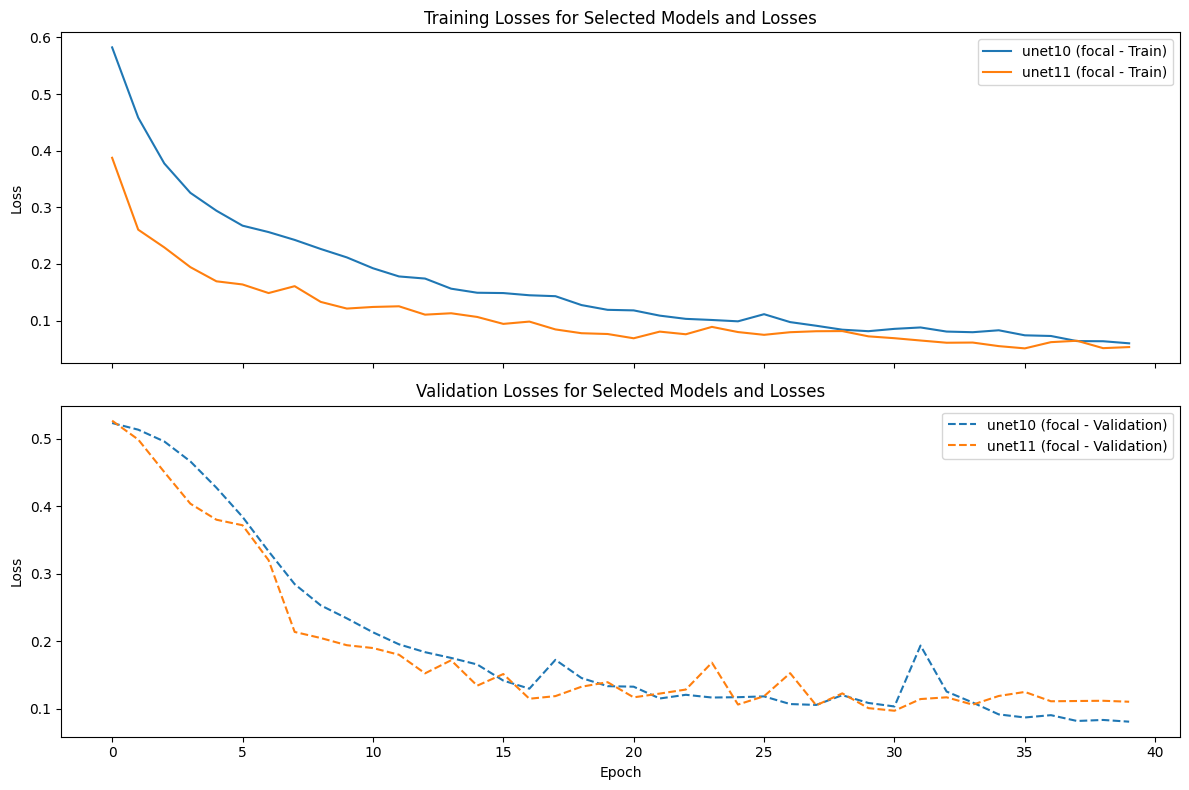

In [ ]:
compare_selected_models_losses(models_losses_per_loss, 'unet10', 'focal', 'unet11', 'focal', model_names)

In [ ]:
def compare_multiple_losses(models_losses, selected_pairs, figsize=(12, 8)):
    # Function to extract losses for a selected model and loss
    def extract_losses(selected_model, selected_loss):
        if selected_model in models_losses and selected_loss in models_losses[selected_model]:
            loss_values = models_losses[selected_model][selected_loss]
            train_loss_values, val_loss_values = zip(*loss_values)
            return train_loss_values, val_loss_values
        else:
            return None, None

    # Plotting training and validation losses
    fig, (ax_train, ax_val) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    for selected_model, selected_loss in selected_pairs:
        train_losses, val_losses = extract_losses(selected_model, selected_loss)

        # Plot training losses
        if train_losses is not None:
            ax_train.plot(train_losses, label=f'{selected_model} ({selected_loss} - Train)')

        # Plot validation losses
        if val_losses is not None:
            ax_val.plot(val_losses, label=f'{selected_model} ({selected_loss} - Validation)', linestyle='dashed')

    # Set titles and labels
    ax_train.set_title(f'Training Losses')
    ax_train.set_ylabel('Loss')
    ax_train.legend()

    ax_val.set_title(f'Validation Losses')
    ax_val.set_xlabel('Epoch')
    ax_val.set_ylabel('Loss')
    ax_val.legend()

    plt.tight_layout()
    plt.show()

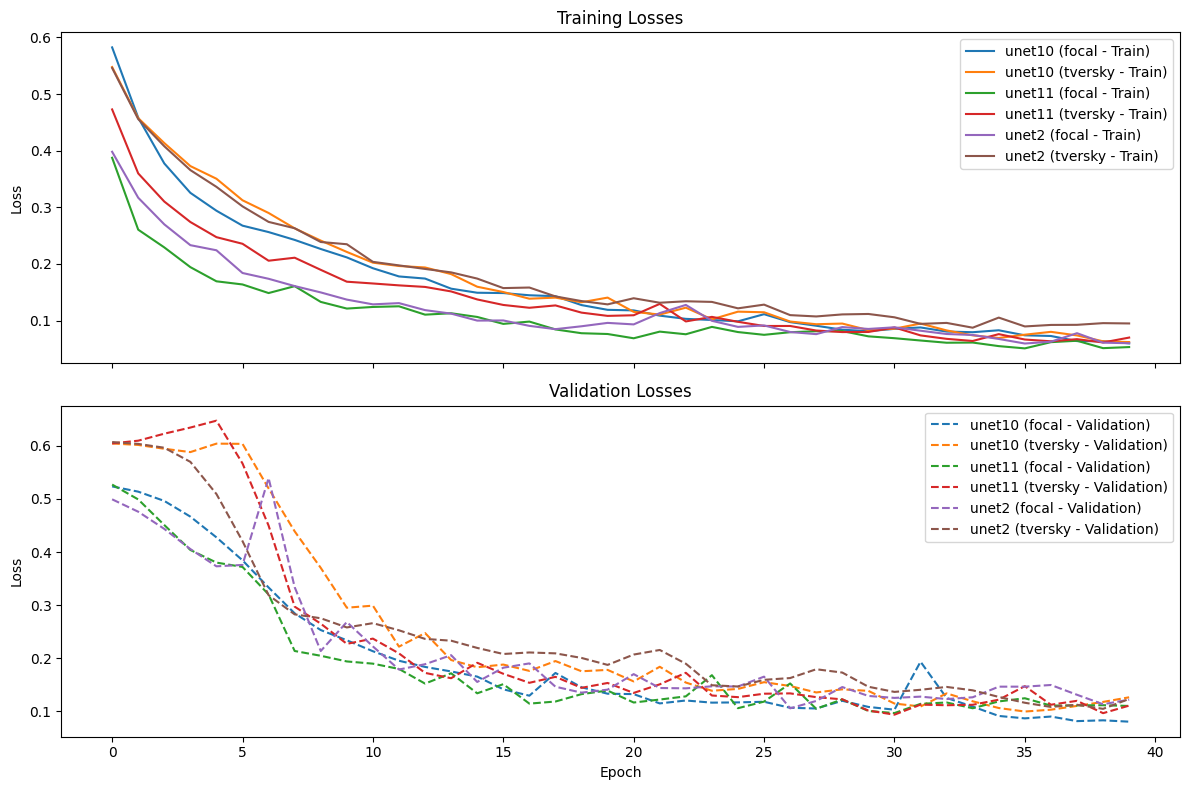

In [ ]:
compare_multiple_losses(models_losses_per_loss, [('unet10', 'focal'), ('unet10', 'tversky'), ('unet11', 'focal'), ('unet11', 'tversky'), ('unet2', 'focal'), ('unet2', 'tversky')])

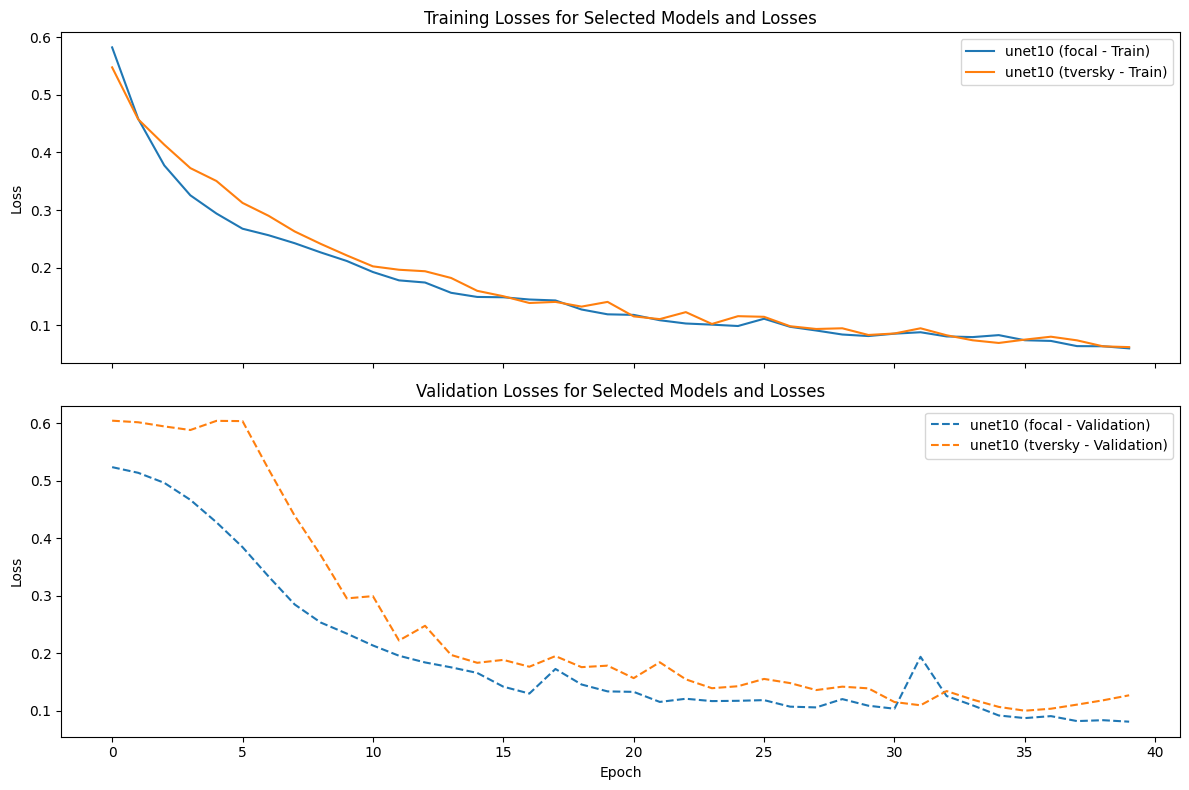

In [ ]:
compare_selected_models_losses(models_losses_per_loss, 'unet10', 'focal', 'unet10', 'tversky', model_names)

**My observation:** unet10 with focal loss provides overall better results than all other models.

In [ ]:
print_model_scores_table(models_scores_per_loss)

╒═════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════╕
│         │ regnet                                                       │ unet10                                                       │ unet11                                                       │ unet2                                                        │
│         │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │ train/val/test                                               │
╞═════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════╪════════

**My answer:**

**Overall Model Performance:**

unet10 with focal loss performs the best across all combinations of models and losses I compare it this notebook.

Focal and tversky losses provide  better results for all models.


**Model Robustness:**

unet10 with focal loss scores for train,val, and test datasets are: 0.8989999890327454, 0.8100000321865082, 0.7419999837875366.
It seems the most robust performance across different models. In addition unet10 exhibited more robust performance across different losses.

The models are sensitive to the choice of loss function. All model preformed badly with the dice loss.

**Training Dynamics:**

The training loss consistently decreases and approaches a stable value afther about 15 epochs, which suggests that the models are converging.
There were no notable differences in training stability or convergence speed.

**Overfitting Analysis:**

There is  some overfitting accross all models and all losses. Unet10 seems to mitigate overfitting a little bit more effectively than some of the models.

**Generalization Capability:**

I evaluated the models's performance on a test set to assess generalization capabilities.

